# Projet ODATA : Catégorisation de capteurs de pollution en fonction de leur environnement
### Binôme : Elie Saleh et Raphaël Brochenin 


## 2 - Catégorisation de capteurs de pollution en fonction de leur environnement

Chargement des modules nécessaires au projet

In [1]:
# Modules qui servent à faire l'affichage, des calculs mathématiques et à obtenir l'estampille
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns 
from datetime import datetime
import matplotlib.pyplot as plt

# Modules qui implémentent les méthodes de réduction des dimensions et les algorithmes de clustering
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

Il faudra créer à partir de la racine du répertoire qui contient ce fichier jupiter, un répertoire "data", et un second qui sera à l'intérieur de "data" et qui portera le nom de "images".
Le répertoire "data" doit contenir les fichiers suivants : 
* donnees_environnement_capteurs.xlsx
* donnees_mesures_PM2_5.xlsx

In [2]:
DATA_FOLDER_PATH="./data"
DATA_IMG_FOLDER_PATH="./data/images"

Chargement des données pour le partitionnement et la vérification

In [3]:
donnees = pd.read_excel(f"{DATA_FOLDER_PATH}/donnees_environnement_capteurs.xlsx")
mesures = pd.read_excel(f"{DATA_FOLDER_PATH}/donnees_mesures_PM2_5.xlsx")

### 2-1 : EXAMEN DES DONNEES

Description de ce que contient le jeu de données de la variable "donnees"

In [4]:
donnees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   INDEX                                     97 non-null     object 
 1   Typologie de la zone                      97 non-null     object 
 2   Type de voie                              97 non-null     object 
 3   Nombre de voies                           97 non-null     object 
 4   Distance capteur / voie                   97 non-null     object 
 5   Position capteurs                         97 non-null     object 
 6   Presence d'arbres                         97 non-null     object 
 7   Feuille d arbres                          97 non-null     object 
 8   Morphologie urbaine                       97 non-null     object 
 9   Hauteur des batiments                     97 non-null     object 
 10  Distance capteur / batiment             

Visualisation des données

In [5]:
donnees.head()

,INDEX,Typologie de la zone,Type de voie,Nombre de voies,Distance capteur / voie,Position capteurs,Presence d'arbres,Feuille d arbres,Morphologie urbaine,Hauteur des batiments,Distance capteur / batiment,Particularite,Trafic Routier/ vehicule leger (TMJA),Trafic Routier/ poids lourds (TMJA),Trafic Routier/ 2 roues (TMJA),emission moyenne annuelle (kg/maille/an),Donnees Cartographie
0,c1,centre ville,Rue droite,Boulevard a 3 voies de circulation et circulat...,1 a 2 m,Parking 4 roues et Arbre,Range arbres,NON en hiver,Batiments de deux cotes,R+2,1 a 2 m,pas de particuarite,14185,366,233,3242,32.400002
1,c2,centre ville,Rue droite,Boulevard a 3 voies de circulation et circulat...,1 a 2 m,Parking 4 roues,Range arbres,NON en hiver,Batiments de deux cotes,R+1,2 a 4 m,Administration,14185,366,233,3242,32.400002
2,c3,centre ville,Intersection en T,Boulevard a 3 voies de circulation et circulat...,1 a 2 m,Arbre,Range arbres,NON en hiver,Batiments de deux cotes,R+1,1 a 2 m,Feu,14185,366,233,3242,26.799999
3,c4,centre ville,Intersection en T,Boulevard a 3 voies de circulation et circulat...,1 a 2 m,Parking 4 roues,Range arbres,NON en hiver,Batiments de deux cotes,R+1,1 a 2 m,Etablissement enseignement,14185,366,233,3242,37.000000
4,c5,centre ville,Rue droite,Boulevard a 3 voies de circulation et circulat...,1 a 2 m,Parking 4 roues et Arbre,Range arbres,NON en hiver,Batiments de deux cotes,R+2,1 a 2 m,pas de particuarite,14185,366,233,3242,27.500000


Isole les variables numériques du jeu de données

In [6]:
donnees_numeriques = donnees[["Trafic Routier/ vehicule leger (TMJA)","Trafic Routier/ poids lourds (TMJA)","Trafic Routier/  2 roues (TMJA)","emission moyenne annuelle (kg/maille/an)","Donnees Cartographie"]]
index_column = donnees["INDEX"]

In [7]:
donnees_numeriques

,Trafic Routier/ vehicule leger (TMJA),Trafic Routier/ poids lourds (TMJA),Trafic Routier/ 2 roues (TMJA),emission moyenne annuelle (kg/maille/an),Donnees Cartographie
0,14185,366,233,3242,32.400002
1,14185,366,233,3242,32.400002
2,14185,366,233,3242,26.799999
3,14185,366,233,3242,37.000000
4,14185,366,233,3242,27.500000
...,...,...,...,...,...
92,800,0,0,2991,26.100000
93,800,0,0,2991,27.100000
94,800,0,0,2270,19.799999
95,7530,5,121,2270,23.299999


Dénombrement des valeurs manquantes du jeu de données

In [8]:
donnees.isna().sum()

INDEX                                       0
Typologie de la zone                        0
Type de voie                                0
Nombre de voies                             0
Distance capteur / voie                     0
Position capteurs                           0
Presence d'arbres                           0
Feuille d arbres                            0
Morphologie urbaine                         0
Hauteur des batiments                       0
Distance capteur / batiment                 0
Particularite                               0
Trafic Routier/ vehicule leger (TMJA)       0
Trafic Routier/ poids lourds (TMJA)         0
Trafic Routier/  2 roues (TMJA)             0
emission moyenne annuelle (kg/maille/an)    0
Donnees Cartographie                        0
dtype: int64

On remarque qu'il n'y a pas de valeurs manquantes.

### 2-2 : PRETRAITEMENT DES DONNEES

Description statistique du jeu de données avec seulement les variables numériques

In [9]:
donnees_numeriques.describe()

,Trafic Routier/ vehicule leger (TMJA),Trafic Routier/ poids lourds (TMJA),Trafic Routier/ 2 roues (TMJA),emission moyenne annuelle (kg/maille/an),Donnees Cartographie
count,97.000000,97.000000,97.000000,97.000000,97.000000
mean,6151.216495,126.824742,94.525773,2671.577320,24.958763
std,7434.939875,177.637037,125.879332,607.813257,6.183223
min,800.000000,0.000000,0.000000,747.000000,14.400000
25%,800.000000,0.000000,0.000000,2182.000000,20.700001
50%,3498.000000,0.000000,58.000000,2991.000000,24.500000
75%,7530.000000,226.000000,121.000000,3242.000000,27.799999
max,31424.000000,646.000000,511.000000,3604.000000,47.400002


On observe que l'écart-type de certaines variables est bien plus grand que leurs moyennes.
Cela indiquerait une présence de potentielles valeurs aberrantes.

Histogramme des variables numériques

array([[<AxesSubplot:title={'center':'Trafic Routier/ vehicule leger (TMJA)'}>,
        <AxesSubplot:title={'center':'Trafic Routier/ poids lourds (TMJA)'}>],
       [<AxesSubplot:title={'center':'Trafic Routier/  2 roues (TMJA)'}>,
        <AxesSubplot:title={'center':'emission moyenne annuelle (kg/maille/an)'}>],
       [<AxesSubplot:title={'center':'Donnees Cartographie'}>,
        <AxesSubplot:>]], dtype=object)

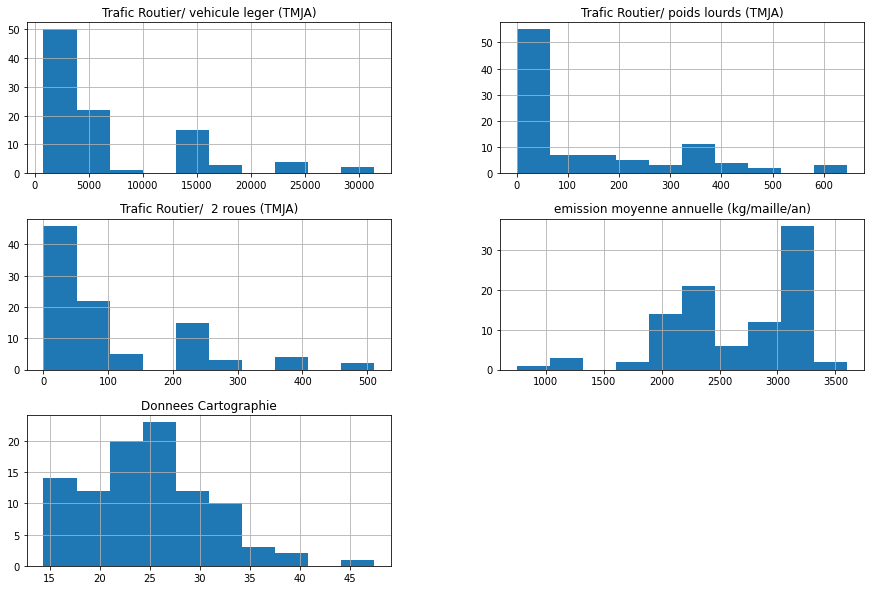

In [10]:
donnees_numeriques.hist(figsize=(15,10))

Visualisation des valeurs aberrantes

Boîte à moustaches des variables numériques

In [11]:
for name in donnees_numeriques.columns:
    fig = px.box(donnees_numeriques[name], y=name,points="all")
    fig.show()

Traitement des valeurs aberrantes.
On les remplace par la valeur médiane de la variable en question.

In [12]:
donnees_numeriques_pretraitees = donnees_numeriques.copy(deep=True)

seuil_aberation=1.5
pourcentage_premier_quartile = 25
pourcentage_deuxieme_quartile = 50
pourcentage_dernier_quartile = 75
res={}

for name in donnees_numeriques_pretraitees.columns:
    
    res[f"{name}"]=[]
    q1=np.percentile(donnees_numeriques_pretraitees[name],pourcentage_premier_quartile)
    median = np.percentile(donnees_numeriques_pretraitees[name],pourcentage_deuxieme_quartile)
    q3=np.percentile(donnees_numeriques_pretraitees[name],pourcentage_dernier_quartile)
    distance_interquartile=abs(q1-q3)
    
    for index, element in enumerate(donnees_numeriques_pretraitees[name].values):
        if element>q3+seuil_aberation*distance_interquartile or element<q1-seuil_aberation*distance_interquartile:
            res[f"{name}"].append(donnees["INDEX"][index])
            donnees_numeriques_pretraitees[name][index]=median

C:\Users\ElieS\AppData\Local\Temp/ipykernel_20896/3490237103.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



On connaît le nom de ces valeurs aberrantes.

In [13]:
res

{'Trafic Routier/ vehicule leger (TMJA)': ['c8',
  'c9',
  'c10',
  'c37',
  'c38',
  'c39',
  'c50',
  'c51',
  'c66'],
 'Trafic Routier/ poids lourds (TMJA)': ['c37', 'c38', 'c39'],
 'Trafic Routier/  2 roues (TMJA)': ['c37', 'c38', 'c39', 'c50', 'c51', 'c66'],
 'emission moyenne annuelle (kg/maille/an)': [],
 'Donnees Cartographie': ['c18', 'c20', 'c50']}

On constate qu'il n'y avait pas beaucoup de valeurs aberrantes sur les données et aucune donnée n'est manquante. On pouvait observer qu'il y avait au maximum 10% de valeurs aberrantes dans les données numériques.

On voit bien ci-dessous que les valeurs aberrantes ont été remplacées

In [14]:
donnees_numeriques.describe()

,Trafic Routier/ vehicule leger (TMJA),Trafic Routier/ poids lourds (TMJA),Trafic Routier/ 2 roues (TMJA),emission moyenne annuelle (kg/maille/an),Donnees Cartographie
count,97.000000,97.000000,97.000000,97.000000,97.000000
mean,6151.216495,126.824742,94.525773,2671.577320,24.958763
std,7434.939875,177.637037,125.879332,607.813257,6.183223
min,800.000000,0.000000,0.000000,747.000000,14.400000
25%,800.000000,0.000000,0.000000,2182.000000,20.700001
50%,3498.000000,0.000000,58.000000,2991.000000,24.500000
75%,7530.000000,226.000000,121.000000,3242.000000,27.799999
max,31424.000000,646.000000,511.000000,3604.000000,47.400002


In [15]:
donnees_numeriques_pretraitees.describe()

,Trafic Routier/ vehicule leger (TMJA),Trafic Routier/ poids lourds (TMJA),Trafic Routier/ 2 roues (TMJA),emission moyenne annuelle (kg/maille/an),Donnees Cartographie
count,97.000000,97.000000,97.000000,97.000000,97.000000
mean,4301.474227,106.845361,71.938144,2671.577320,24.411340
std,4726.848684,152.417214,91.745324,607.813257,5.312640
min,800.000000,0.000000,0.000000,747.000000,14.400000
25%,800.000000,0.000000,0.000000,2182.000000,20.700001
50%,3498.000000,0.000000,58.000000,2991.000000,24.500000
75%,4755.000000,219.000000,80.000000,3242.000000,27.700001
max,15429.000000,495.000000,302.000000,3604.000000,37.000000


On encode ici l'ensemble des données non numériques

In [16]:
colonnes = donnees.columns.values
colonnesNumeriques = ["Trafic Routier/ vehicule leger (TMJA)","Trafic Routier/ poids lourds (TMJA)","Trafic Routier/  2 roues (TMJA)","emission moyenne annuelle (kg/maille/an)","Donnees Cartographie"]
colonnesCategoriques = [c for c in colonnes if c not in colonnesNumeriques]

In [17]:
encoderOHE = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoderOrdinal = OrdinalEncoder()
scaler = StandardScaler()

donneesOHE = encoderOHE.fit_transform(donnees[colonnesCategoriques])
donneesOrdinal = encoderOrdinal.fit_transform(donnees[colonnesCategoriques])
donneesNumeriquesStandard = scaler.fit_transform(donnees_numeriques_pretraitees)

donneesOHE = pd.DataFrame(donneesOHE)
donneesOrdinal = pd.DataFrame(donneesOrdinal)
donneesNumeriquesStandard = pd.DataFrame(donneesNumeriquesStandard)

donneesOHEStandard = pd.concat([donneesOHE, donneesNumeriquesStandard], axis = 1 , ignore_index=True)
donneesOrdinalStandard = pd.concat([donneesOrdinal, donneesNumeriquesStandard], axis = 1 , ignore_index=True)

donneesOrdinalStandard.drop(0, axis=1, inplace=True)
donneesOrdinalStandard.columns=donnees.columns[1:]

listeJeuxDeDonnees = [donneesOrdinalStandard , donneesOHEStandard]

On observe que : 

* OneHotEncoder établit une liste de toutes les uniques valeurs du jeu de données. Mais au lieu de directement les transformer en nombres comme OrdinalEncoder, OneHotEncoder va créer une colonne pour chacune de ces variables. Puis, pour chaque objet, il va attribuer la valeur 1 (vrai) si la valeur est celle prise par l’objet et 0 (faux) si la valeur n’est pas prise par l’objet

* OrdinalEncoder attribue à chaque unique valeur un entier, en ordre croissant de lecture (par défaut). 

In [18]:
donneesOHEStandard

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.101795,1.709130,1.764652,0.943359,1.511520
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.101795,1.709130,1.764652,0.943359,1.511520
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.101795,1.709130,1.764652,0.943359,0.451954
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.101795,1.709130,1.764652,0.943359,2.381877
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.101795,1.709130,1.764652,0.943359,0.584400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.744611,-0.704647,-0.788180,0.528258,0.319508
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.744611,-0.704647,-0.788180,0.528258,0.508716
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.744611,-0.704647,-0.788180,-0.664124,-0.872503
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.686567,-0.671672,0.537539,-0.664124,-0.210275


In [19]:
donneesOrdinalStandard

,Typologie de la zone,Type de voie,Nombre de voies,Distance capteur / voie,Position capteurs,Presence d'arbres,Feuille d arbres,Morphologie urbaine,Hauteur des batiments,Distance capteur / batiment,Particularite,Trafic Routier/ vehicule leger (TMJA),Trafic Routier/ poids lourds (TMJA),Trafic Routier/ 2 roues (TMJA),emission moyenne annuelle (kg/maille/an),Donnees Cartographie
0,2.0,3.0,0.0,0.0,7.0,2.0,1.0,1.0,3.0,1.0,11.0,2.101795,1.709130,1.764652,0.943359,1.511520
1,2.0,3.0,0.0,0.0,4.0,2.0,1.0,1.0,2.0,4.0,1.0,2.101795,1.709130,1.764652,0.943359,1.511520
2,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,4.0,2.101795,1.709130,1.764652,0.943359,0.451954
3,2.0,0.0,0.0,0.0,4.0,2.0,1.0,1.0,2.0,1.0,3.0,2.101795,1.709130,1.764652,0.943359,2.381877
4,2.0,3.0,0.0,0.0,7.0,2.0,1.0,1.0,3.0,1.0,11.0,2.101795,1.709130,1.764652,0.943359,0.584400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,4.0,3.0,2.0,3.0,7.0,2.0,1.0,1.0,5.0,3.0,6.0,-0.744611,-0.704647,-0.788180,0.528258,0.319508
93,4.0,3.0,3.0,1.0,5.0,2.0,1.0,1.0,0.0,3.0,9.0,-0.744611,-0.704647,-0.788180,0.528258,0.508716
94,4.0,4.0,2.0,3.0,7.0,2.0,3.0,1.0,3.0,1.0,11.0,-0.744611,-0.704647,-0.788180,-0.664124,-0.872503
95,4.0,3.0,3.0,3.0,7.0,2.0,3.0,1.0,3.0,1.0,5.0,0.686567,-0.671672,0.537539,-0.664124,-0.210275


Nous travaillerons sur le jeu de données issu de la variable "donneesOrdinalStandard"

In [20]:
donneesOrdinalStandard.describe()

,Typologie de la zone,Type de voie,Nombre de voies,Distance capteur / voie,Position capteurs,Presence d'arbres,Feuille d arbres,Morphologie urbaine,Hauteur des batiments,Distance capteur / batiment,Particularite,Trafic Routier/ vehicule leger (TMJA),Trafic Routier/ poids lourds (TMJA),Trafic Routier/ 2 roues (TMJA),emission moyenne annuelle (kg/maille/an),Donnees Cartographie
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01
mean,2.701031,2.453608,2.371134,1.824742,5.185567,1.247423,1.103093,1.371134,3.412371,3.134021,6.814433,8.584199e-17,-7.668551e-17,8.355287e-17,-3.124648e-16,-8.504079e-16
std,1.362939,1.274923,1.804621,1.421636,2.078310,0.935759,1.094347,0.927806,1.730562,2.238996,3.462086,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.446111e-01,-7.046475e-01,-7.881802e-01,-3.182845e+00,-1.894227e+00
25%,2.000000,2.000000,0.000000,0.000000,5.000000,0.000000,0.000000,1.000000,2.000000,1.000000,4.000000,-7.446111e-01,-7.046475e-01,-7.881802e-01,-8.096576e-01,-7.022157e-01
50%,3.000000,3.000000,3.000000,3.000000,6.000000,2.000000,1.000000,1.000000,4.000000,3.000000,8.000000,-1.708640e-01,-7.046475e-01,-1.527113e-01,5.282577e-01,1.677515e-02
75%,4.000000,3.000000,4.000000,3.000000,7.000000,2.000000,1.000000,2.000000,5.000000,5.000000,11.000000,9.644518e-02,7.396623e-01,8.832860e-02,9.433587e-01,6.222414e-01
max,4.000000,5.000000,5.000000,4.000000,8.000000,2.000000,3.000000,3.000000,6.000000,6.000000,11.000000,2.366340e+00,2.559888e+00,2.520641e+00,1.542030e+00,2.381877e+00


### 2-4 : RECHERCHE DE CORRELATION

Observation de la matrice de corrélation pour le jeu de données prétraité des variables numériques 

<AxesSubplot:>

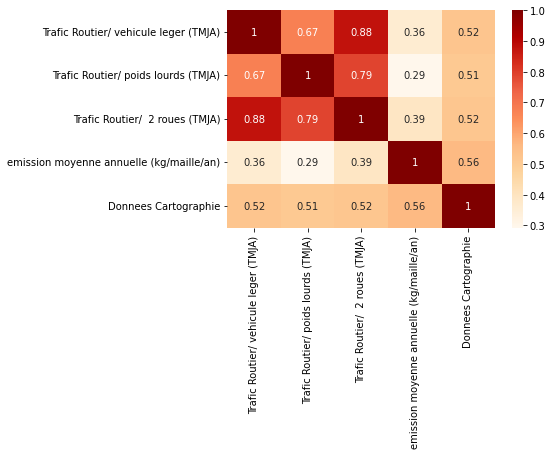

In [21]:
sns.heatmap(donnees_numeriques_pretraitees.corr(),cmap="OrRd",annot=True)

Observation de la matrice de corrélation de la variable donneesOrdinalStandard

<AxesSubplot:>

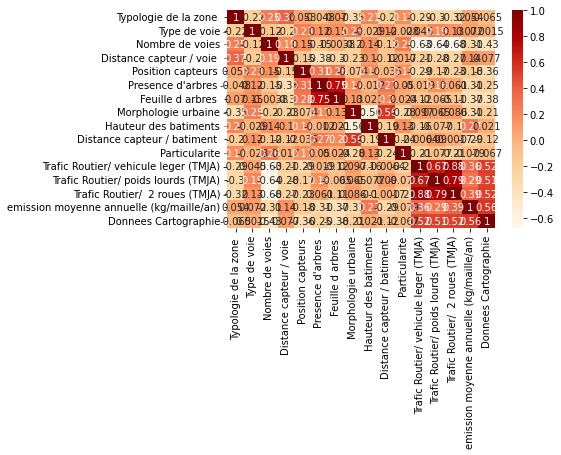

In [22]:
sns.heatmap(donneesOrdinalStandard.corr(),cmap="OrRd",annot=True)

### 2-3 et 2-5 : VISUALISATION DES DONNEES et ANALYSE DES DONNEES

##### ACP

Centre et réduit le jeu de données

In [23]:
# Jeu de données originel
X=donneesOrdinalStandard.copy(deep=True)

# Centrer et réduire les donnees
X_array = X.to_numpy()
scaler = StandardScaler()
scaler.fit(X_array)
Z_array=scaler.transform(X_array)

# Mettre dans un dataframe les données centrées réduites
Z_df=pd.DataFrame(Z_array,columns=X.columns)

# Vérifie que les variables sont bien centrées et réduites
Z_df.var(),Z_df.mean() 

(Typologie de la zone                        1.010417
 Type de voie                                1.010417
 Nombre de voies                             1.010417
 Distance capteur / voie                     1.010417
 Position capteurs                           1.010417
 Presence d'arbres                           1.010417
 Feuille d arbres                            1.010417
 Morphologie urbaine                         1.010417
 Hauteur des batiments                       1.010417
 Distance capteur / batiment                 1.010417
 Particularite                               1.010417
 Trafic Routier/ vehicule leger (TMJA)       1.010417
 Trafic Routier/ poids lourds (TMJA)         1.010417
 Trafic Routier/  2 roues (TMJA)             1.010417
 emission moyenne annuelle (kg/maille/an)    1.010417
 Donnees Cartographie                        1.010417
 dtype: float64,
 Typologie de la zone                       -8.011919e-17
 Type de voie                               -1.831296e-16
 No

On effectue une ACP pour visualiser les données

In [24]:
pca = PCA(n_components=Z_df.columns.size)
pca.fit(Z_array)

print(pca.explained_variance_ratio_.cumsum()) # pourcentage cumulé de l'inertie expliquée par chaque axe 
print(pca.explained_variance_) # l'inertie expliquée par chaque axe

[0.26258476 0.45587443 0.5729961  0.64504811 0.70836405 0.76026103
 0.80577534 0.84384246 0.87494648 0.90265568 0.92856698 0.95084573
 0.96858092 0.98304249 0.99424617 1.        ]
[4.24512029 3.12484964 1.893467   1.16484086 1.02360774 0.83900107
 0.73581466 0.61541849 0.5028484  0.44796541 0.41889923 0.36017324
 0.28671878 0.23379548 0.18112613 0.09302024]


In [25]:
print(pca.explained_variance_.mean()) # la moyenne des inerties expliquées par chaque axe

1.010416666666666


Graphe de l'inertie expliquée cumulée en bleu et graphe de l'inertie expliquée en rouge

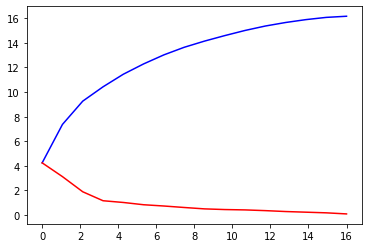

In [26]:
x = np.linspace(0,pca.explained_variance_.size,Z_df.columns.size)

plt.plot(x,pca.explained_variance_.cumsum(),"b")
plt.plot(x,pca.explained_variance_,"r")
plt.show()

Graphe du pourcentage cumulé de l'inertie expliquée en bleu et graphe du pourcentage de l'inertie expliquée en rouge

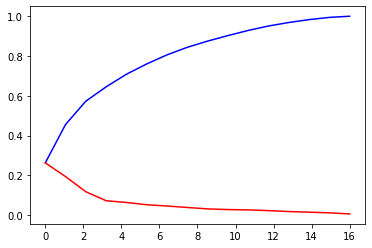

In [27]:
plt.plot(x,pca.explained_variance_ratio_.cumsum(),"b")
plt.plot(x,pca.explained_variance_ratio_,"r")
plt.show()

D'après les critères suivants : 
* Part inertie : On devrait prendre les 5 premiers axes afin d’avoir un seuil de qualité globale supérieur à 0,7. 
* Règle Kaiser : On ne devrait retenir qu’au plus les 5 premiers axes dont les valeurs propres sont supérieures à la moyenne des inerties expliquées par chaque axe, dont la valeur est égale à 1,01. 
* Méthode "COUDE" : On ne devrait retenir que les 3 premiers axes, en raison de la figure ci-dessus qui indique que la rupture de pente du graphe se fait à la 4ème valeur propre.

On choisit de ne retenir que les 3 premiers axes pour être en accord avec les 2 derniers critères. Le risque est que ce sous-espace vectoriel, de 3 dimensions, ne soit pas assez représentatif du jeu de données, car sa qualité globale est autour des 0,6. 

On souhaite appliquer la réduction de dimension sur les données

On stocke les valeurs des 3 premiers valeurs propres, ainsi que le pourcentage d'inertie expliquée pour les 3 premiers axes

In [28]:
lambda_1,lambda_2,lambda_3=pca.explained_variance_[0],pca.explained_variance_[1],pca.explained_variance_[2]
ratio_lambda_1,ratio_lambda_2,ratio_lambda_3=pca.explained_variance_ratio_[0],pca.explained_variance_ratio_[1],pca.explained_variance_ratio_[2]

On applique la réduction de dimension

In [29]:
#nbr dim réduction
dim=3

pca_reduction = PCA(n_components=dim)
pca_reduction.fit(Z_array)
print(pca_reduction.transform(Z_array))
X_new,Y_new,Z_new = pca_reduction.transform(Z_array).T

[[ 3.51127482e+00  3.35319727e-02 -2.37848462e+00]
 [ 4.29674214e+00  6.58485068e-01 -4.72451226e-01]
 [ 3.92596716e+00 -3.61054840e-01 -2.47184797e-02]
 [ 4.26249213e+00 -5.17696199e-01 -6.91013059e-01]
 [ 3.20442042e+00  2.68952629e-01 -2.35250303e+00]
 [ 4.40736580e+00 -1.50936836e+00  1.20053792e+00]
 [ 3.85996120e+00  1.14931993e-01 -8.29340858e-01]
 [ 2.93576505e+00  3.10793659e-01 -1.85813055e+00]
 [ 3.05602242e+00  1.46939125e+00 -1.26803946e+00]
 [ 3.11879827e+00 -3.47917570e-02 -1.75358507e+00]
 [-1.30121946e+00 -3.52962615e+00  5.01365737e-01]
 [-1.47871966e+00 -3.01729591e+00  2.87751283e-01]
 [-1.63373027e+00 -3.23330797e+00 -1.92650569e-01]
 [-1.33764623e+00 -3.06441245e+00 -4.09540681e-01]
 [-1.47744202e+00 -3.59245362e+00  6.12196861e-01]
 [-1.42531887e+00 -2.99714944e+00 -4.02117372e-01]
 [-1.63471783e+00 -1.38172711e+00 -4.90432763e-01]
 [ 2.82233606e+00 -2.99727972e-01 -2.33489335e+00]
 [ 3.36476997e+00 -3.03887243e-01 -1.60969260e+00]
 [ 3.12195280e+00 -1.07292918e-

Matrice des données transformées par l'ACP

In [30]:
M = pca_reduction.transform(Z_array)[:,:]
M[:,:2].shape

(97, 2)

In [31]:
M[:,:2]

array([[ 3.51127482,  0.03353197],
       [ 4.29674214,  0.65848507],
       [ 3.92596716, -0.36105484],
       [ 4.26249213, -0.5176962 ],
       [ 3.20442042,  0.26895263],
       [ 4.4073658 , -1.50936836],
       [ 3.8599612 ,  0.11493199],
       [ 2.93576505,  0.31079366],
       [ 3.05602242,  1.46939125],
       [ 3.11879827, -0.03479176],
       [-1.30121946, -3.52962615],
       [-1.47871966, -3.01729591],
       [-1.63373027, -3.23330797],
       [-1.33764623, -3.06441245],
       [-1.47744202, -3.59245362],
       [-1.42531887, -2.99714944],
       [-1.63471783, -1.38172711],
       [ 2.82233606, -0.29972797],
       [ 3.36476997, -0.30388724],
       [ 3.1219528 , -0.10729292],
       [ 1.24376393, -0.40801923],
       [ 1.44214946, -0.07758995],
       [ 1.44944568, -0.14351665],
       [ 0.17016086,  1.82210597],
       [-0.2535629 ,  1.93678391],
       [ 0.03030887,  0.28272773],
       [ 0.4102705 ,  1.20926209],
       [ 0.59241791, -2.15407879],
       [ 0.58756946,

Visualisation des 3 premiers plans principaux et factoriels

1er plan principal

Contribution > ax0 : c6 | < : c63
Contribution > ax1 : c70 | < : c15


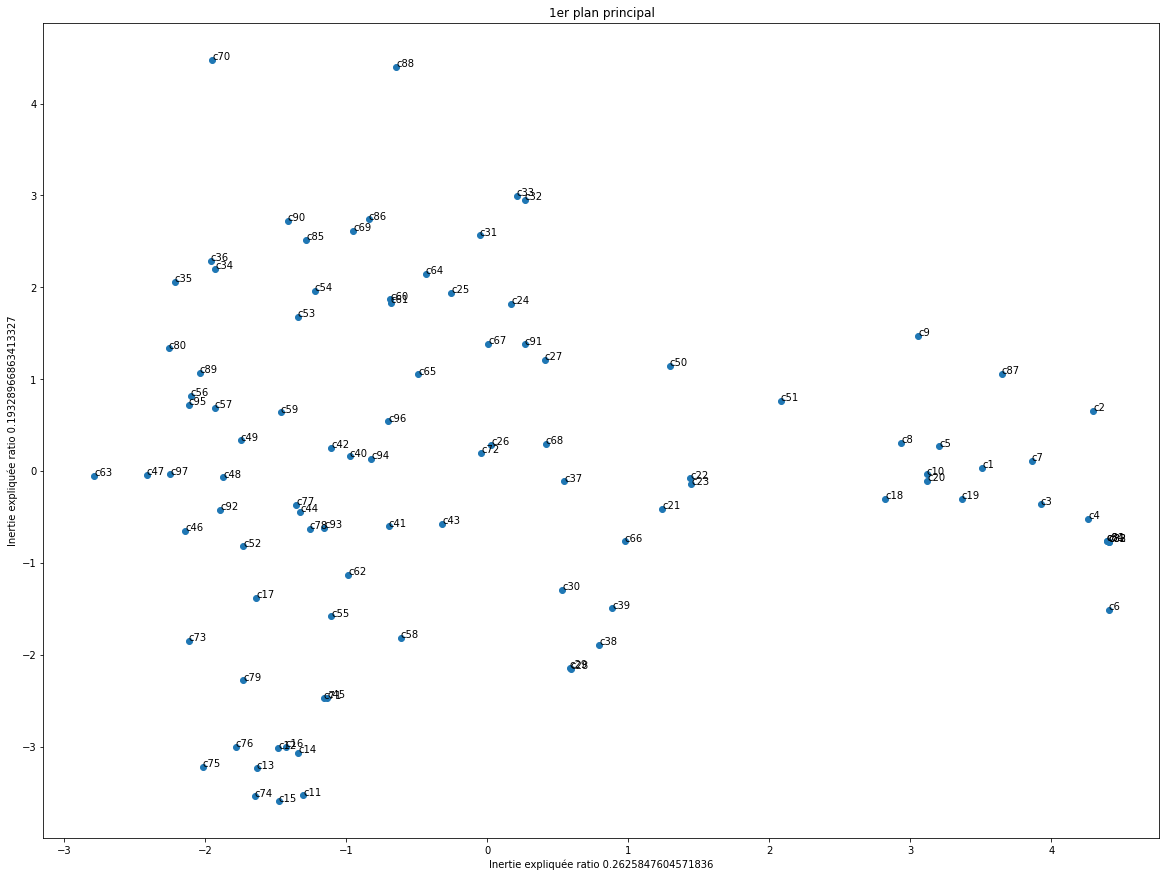

In [32]:
Name_array=index_column.to_numpy()

#Affichage des individus sur le premier plan principal
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)
ax.scatter(X_new, Y_new)
ax.set_xlabel(f"Inertie expliquée ratio {ratio_lambda_1}")
ax.set_ylabel(f"Inertie expliquée ratio {ratio_lambda_2}")
ax.set_title("1er plan principal")

for i, txt in enumerate(Name_array):
    ax.annotate(txt, (X_new[i], Y_new[i]))

# Recherche les individus qui contribuent le plus sur le premier et deuxième axes
contribXMaxNeg=-999
contribXMaxPos=-999
contribYMaxNeg=-999
contribYMaxPos=-999
nomX_MaxPos=""
nomX_MaxNeg=""
nomY_MaxPos=""
nomY_MaxNeg=""
contribDict={}

for i, txt in enumerate(Name_array):

    contribDict[txt]=((X_new[i]**2)/(lambda_1*len(X_new)),(Y_new[i]**2)/(lambda_2*len(X_new)))
    
    if ((X_new[i]**2)/(lambda_1*len(X_new)))>contribXMaxPos and (X_new[i]>0):
        contribXMaxPos = ((X_new[i]**2)/(lambda_1*len(X_new)))
        nomX_MaxPos=txt

    if ((X_new[i]**2)/(lambda_1*len(X_new)))>contribXMaxNeg and (X_new[i]<0):
        contribXMaxNeg = ((X_new[i]**2)/(lambda_1*len(X_new)))
        nomX_MaxNeg=txt
   
    if ((Y_new[i]**2)/(lambda_2*len(X_new)))>contribYMaxPos and (Y_new[i]>0):
        contribYMaxPos=((Y_new[i]**2)/(lambda_2*len(X_new)))
        nomY_MaxPos=txt

    if ((Y_new[i]**2)/(lambda_2*len(X_new)))>contribYMaxNeg and (Y_new[i]<0):
        contribYMaxNeg=((Y_new[i]**2)/(lambda_2*len(X_new)))
        nomY_MaxNeg=txt


print(f"Contribution > ax0 : {nomX_MaxPos} | < : {nomX_MaxNeg}")
print(f"Contribution > ax1 : {nomY_MaxPos} | < : {nomY_MaxNeg}")

2ème plan principal

Contribution > ax0 : c6 | < : c63
Contribution > ax1 : c68 | < : c67


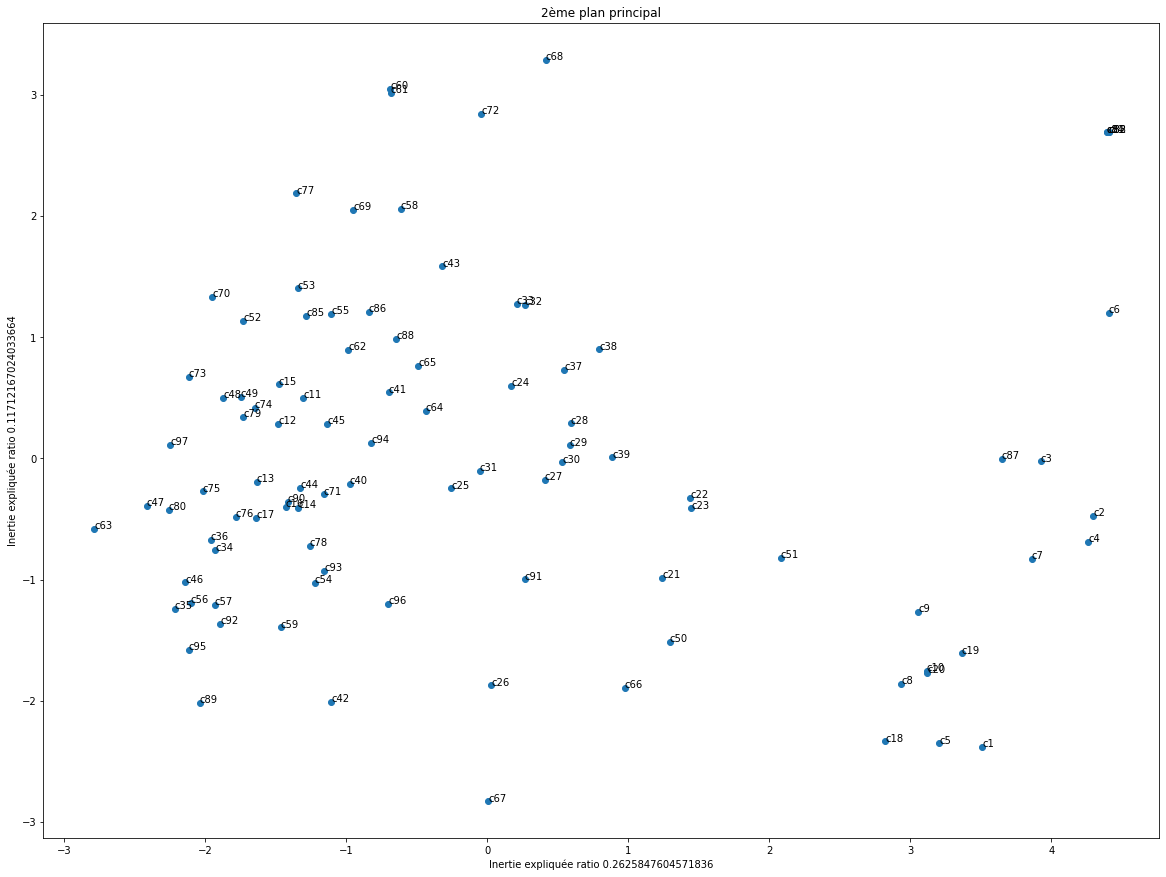

In [33]:
Name_array=index_column.to_numpy()

#Affichage des individus sur le deuxième plan principal
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)
ax.scatter(X_new, Z_new)
ax.set_xlabel(f"Inertie expliquée ratio {ratio_lambda_1}")
ax.set_ylabel(f"Inertie expliquée ratio {ratio_lambda_3}")
ax.set_title("2ème plan principal")

for i, txt in enumerate(Name_array):
    ax.annotate(txt, (X_new[i], Z_new[i]))

# Recherche les individus qui contribuent le plus sur le premier et troisième axes
contribXMaxNeg=-999
contribXMaxPos=-999
contribYMaxNeg=-999
contribYMaxPos=-999
nomX_MaxPos=""
nomX_MaxNeg=""
nomY_MaxPos=""
nomY_MaxNeg=""
contribDict={}
for i, txt in enumerate(Name_array):
 
    contribDict[txt]=((X_new[i]**2)/(lambda_1*len(X_new)),(Z_new[i]**2)/(lambda_3*len(X_new)))

    if ((X_new[i]**2)/(lambda_1*len(X_new)))>contribXMaxPos and (X_new[i]>0):
        contribXMaxPos = ((X_new[i]**2)/(lambda_1*len(X_new)))
        nomX_MaxPos=txt

    if ((X_new[i]**2)/(lambda_1*len(X_new)))>contribXMaxNeg and (X_new[i]<0):
        contribXMaxNeg = ((X_new[i]**2)/(lambda_1*len(X_new)))
        nomX_MaxNeg=txt
   
    if ((Z_new[i]**2)/(lambda_3*len(X_new)))>contribYMaxPos and (Z_new[i]>0):
        contribYMaxPos=((Z_new[i]**2)/(lambda_3*len(X_new)))
        nomY_MaxPos=txt

    if ((Z_new[i]**2)/(lambda_3*len(X_new)))>contribYMaxNeg and (Z_new[i]<0):
        contribYMaxNeg=((Z_new[i]**2)/(lambda_3*len(X_new)))
        nomY_MaxNeg=txt


print(f"Contribution > ax0 : {nomX_MaxPos} | < : {nomX_MaxNeg}")
print(f"Contribution > ax1 : {nomY_MaxPos} | < : {nomY_MaxNeg}")

3ème plan principal

Contribution > ax0 : c70 | < : c15
Contribution > ax1 : c68 | < : c67


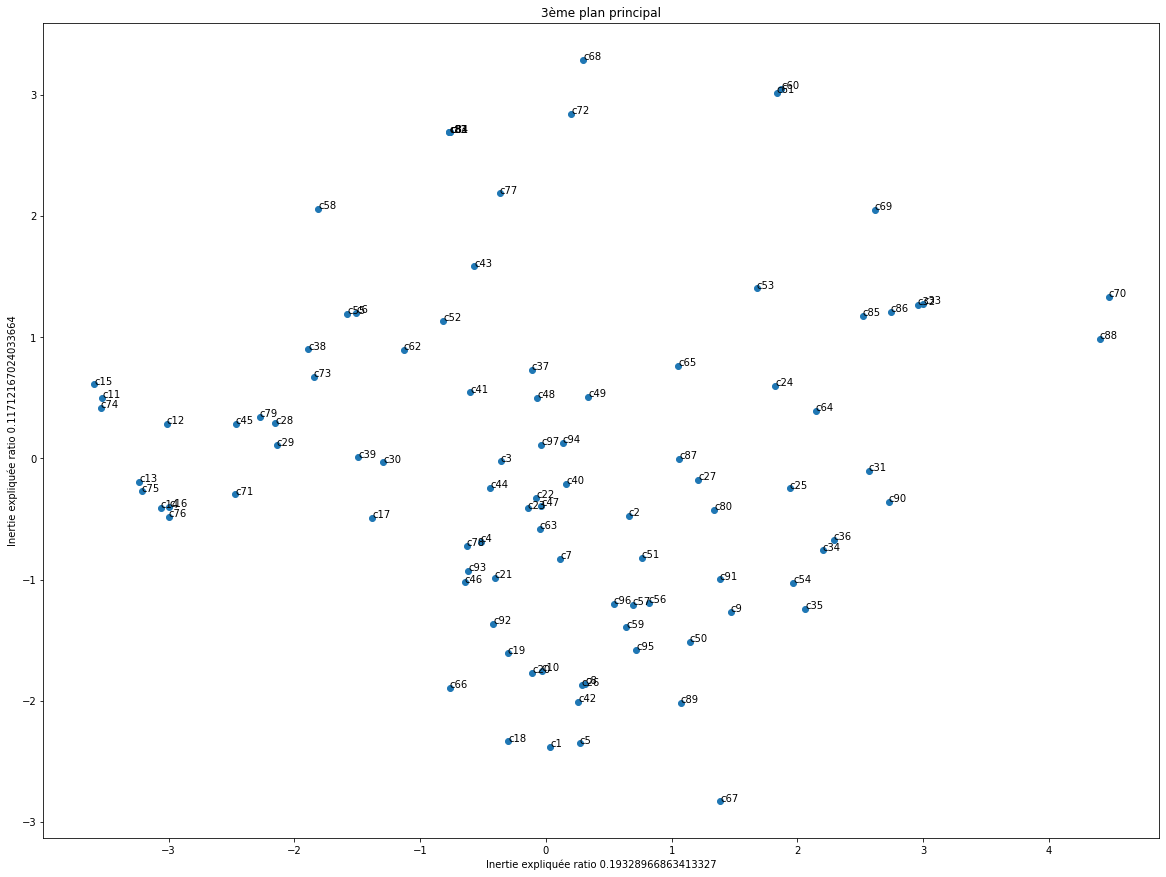

In [34]:
Name_array=index_column.to_numpy()

#Affichage des individus sur le troisième plan principal
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)
ax.scatter(Y_new, Z_new)
ax.set_xlabel(f"Inertie expliquée ratio {ratio_lambda_2}")
ax.set_ylabel(f"Inertie expliquée ratio {ratio_lambda_3}")
ax.set_title("3ème plan principal")

for i, txt in enumerate(Name_array):
    ax.annotate(txt, (Y_new[i], Z_new[i]))

# Recherche les individus qui contribuent le plus sur le deuxième et troisième axes
contribXMaxNeg=-999
contribXMaxPos=-999
contribYMaxNeg=-999
contribYMaxPos=-999
nomX_MaxPos=""
nomX_MaxNeg=""
nomY_MaxPos=""
nomY_MaxNeg=""
contribDict={}
for i, txt in enumerate(Name_array):
    
    contribDict[txt]=((Y_new[i]**2)/(lambda_2*len(X_new)),(Z_new[i]**2)/(lambda_3*len(X_new)))
   
    if ((Y_new[i]**2)/(lambda_2*len(X_new)))>contribXMaxPos and (Y_new[i]>0):
        contribXMaxPos = ((Y_new[i]**2)/(lambda_2*len(X_new)))
        nomX_MaxPos=txt

    if ((Y_new[i]**2)/(lambda_2*len(X_new)))>contribXMaxNeg and (Y_new[i]<0):
        contribXMaxNeg = ((Y_new[i]**2)/(lambda_2*len(X_new)))
        nomX_MaxNeg=txt
   
    if ((Z_new[i]**2)/(lambda_3*len(X_new)))>contribYMaxPos and (Z_new[i]>0):
        contribYMaxPos=((Z_new[i]**2)/(lambda_3*len(X_new)))
        nomY_MaxPos=txt

    if ((Z_new[i]**2)/(lambda_3*len(X_new)))>contribYMaxNeg and (Z_new[i]<0):
        contribYMaxNeg=((Z_new[i]**2)/(lambda_3*len(X_new)))
        nomY_MaxNeg=txt


print(f"Contribution > ax0 : {nomX_MaxPos} | < : {nomX_MaxNeg}")
print(f"Contribution > ax1 : {nomY_MaxPos} | < : {nomY_MaxNeg}")

Calcul de la matrice qui contient les coordonnées des variables sur les 3 premiers facteurs principaux

In [35]:
eigValues_reduction=pca_reduction.explained_variance_
eigVectors_reduction=pca_reduction.components_

list_corr=[]
for k in range(Z_df.columns.size):
    l_tmp=[]
    for j in range(dim):
        l_tmp.append((eigValues_reduction[j]**0.5)*eigVectors_reduction[j][k])
    list_corr.append(l_tmp)
matrix_corr=pd.DataFrame(list_corr)

Observation de cette matrice

In [36]:
matrix_corr

,0,1,2
0,-0.418120,-0.383776,-0.185757
1,0.165942,0.334760,-0.176773
2,-0.785801,-0.154138,0.114149
3,-0.254267,-0.558575,0.294801
4,-0.367459,0.279533,-0.492872
5,-0.046484,0.692516,-0.508467
6,-0.231580,0.648596,-0.460581
7,0.169249,0.684595,0.537993
8,-0.186070,-0.387187,-0.574062
9,0.070692,0.593597,0.343834


Observation des 3 premiers plans factoriels

1er plan factoriel

Typologie de la zone 
Type de voie
Nombre de voies
Distance capteur / voie 
Position capteurs 
Presence d'arbres 
Feuille d arbres 
Morphologie urbaine
Hauteur des batiments
Distance capteur / batiment 
Particularite
Trafic Routier/ vehicule leger (TMJA)
Trafic Routier/ poids lourds (TMJA)
Trafic Routier/  2 roues (TMJA)
emission moyenne annuelle (kg/maille/an)
Donnees Cartographie


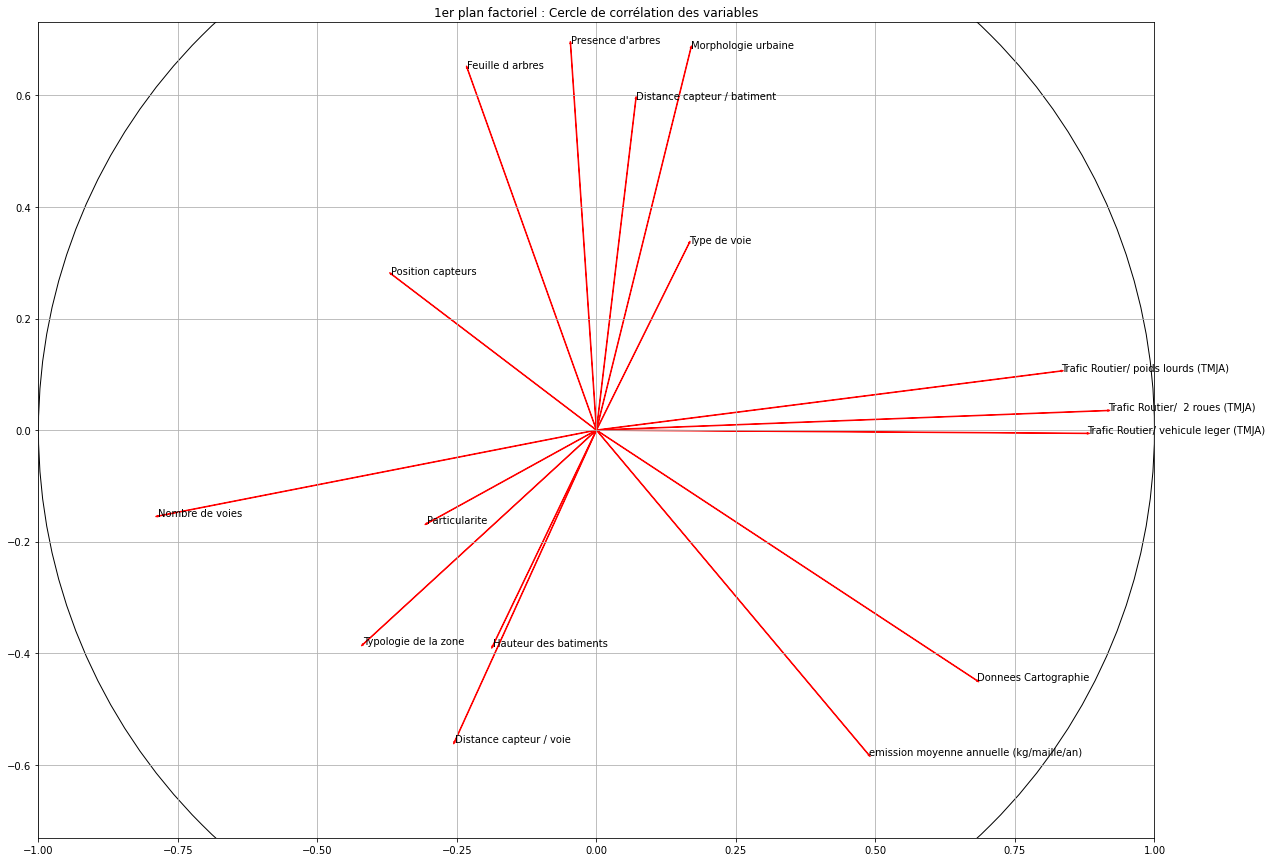

In [37]:
num_ax0=0
num_ax1=1

figure, axes = plt.subplots()

figure.set_figheight(15)
figure.set_figwidth(20)
circle=plt.Circle(( 0 , 0 ),1,fill = False)

# Affichage du premier cercle de corrélation
Name_variable=Z_df.columns
for i, txt in enumerate(Name_variable):
    print(txt)
    plt.arrow(0,0,list_corr[i][0],list_corr[i][1],fc='r', ec='r')
    axes.annotate(txt, (list_corr[i][0], list_corr[i][1]))
plt.gca().add_artist(circle)
plt.title( '1er plan factoriel : Cercle de corrélation des variables' )


plt.axis("equal")
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.grid()
plt.show()

2ème plan factoriel

Typologie de la zone 
Type de voie
Nombre de voies
Distance capteur / voie 
Position capteurs 
Presence d'arbres 
Feuille d arbres 
Morphologie urbaine
Hauteur des batiments
Distance capteur / batiment 
Particularite
Trafic Routier/ vehicule leger (TMJA)
Trafic Routier/ poids lourds (TMJA)
Trafic Routier/  2 roues (TMJA)
emission moyenne annuelle (kg/maille/an)
Donnees Cartographie


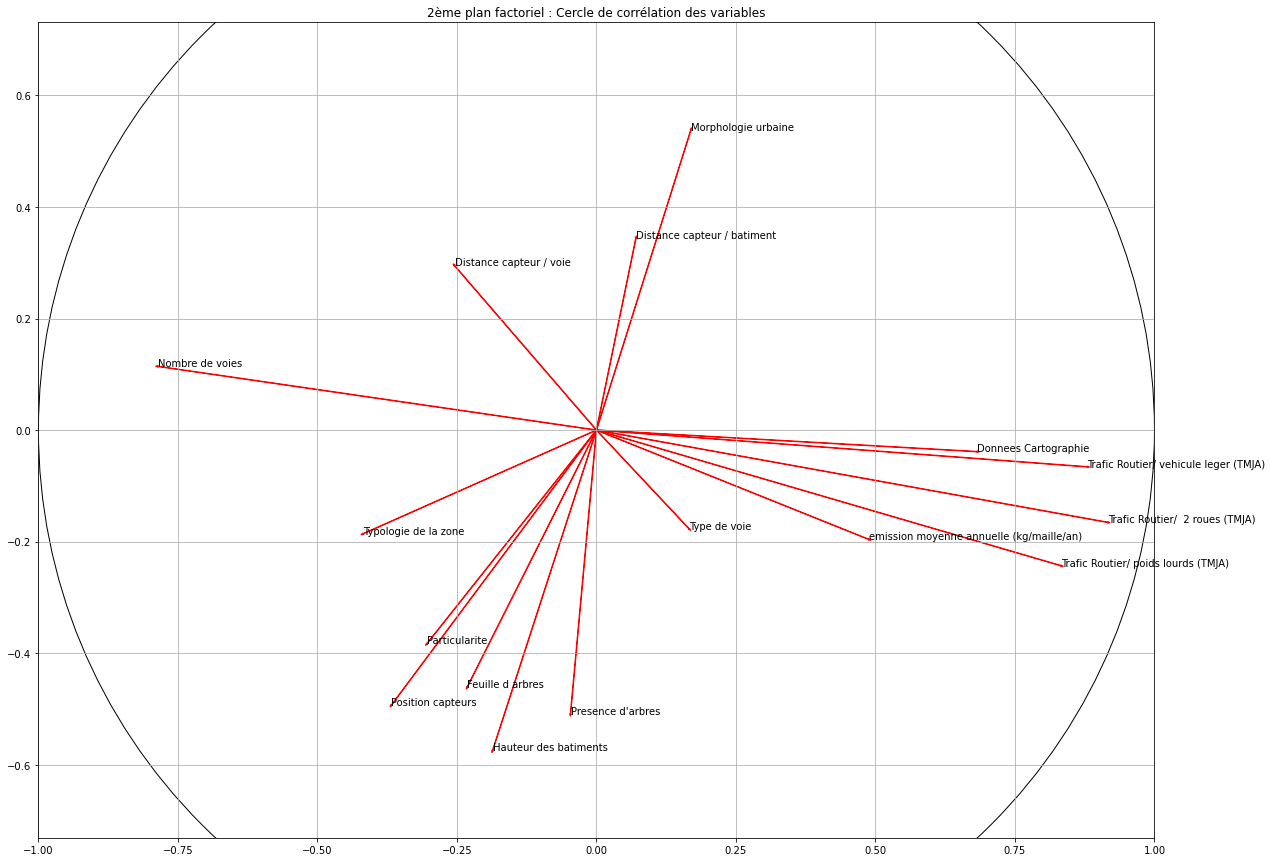

In [38]:
num_ax0=0
num_ax1=1

figure, axes = plt.subplots()

figure.set_figheight(15)
figure.set_figwidth(20)
circle=plt.Circle(( 0 , 0 ),1,fill = False)

# Affichage du deuxième cercle de corrélation
Name_variable=Z_df.columns
for i, txt in enumerate(Name_variable):
    print(txt)
    plt.arrow(0,0,list_corr[i][0],list_corr[i][2],fc='r', ec='r')
    axes.annotate(txt, (list_corr[i][0], list_corr[i][2]))
plt.gca().add_artist(circle)
plt.title( '2ème plan factoriel : Cercle de corrélation des variables' )


plt.axis("equal")
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.grid()
plt.show()

3ème plan factoriel

Typologie de la zone 
Type de voie
Nombre de voies
Distance capteur / voie 
Position capteurs 
Presence d'arbres 
Feuille d arbres 
Morphologie urbaine
Hauteur des batiments
Distance capteur / batiment 
Particularite
Trafic Routier/ vehicule leger (TMJA)
Trafic Routier/ poids lourds (TMJA)
Trafic Routier/  2 roues (TMJA)
emission moyenne annuelle (kg/maille/an)
Donnees Cartographie


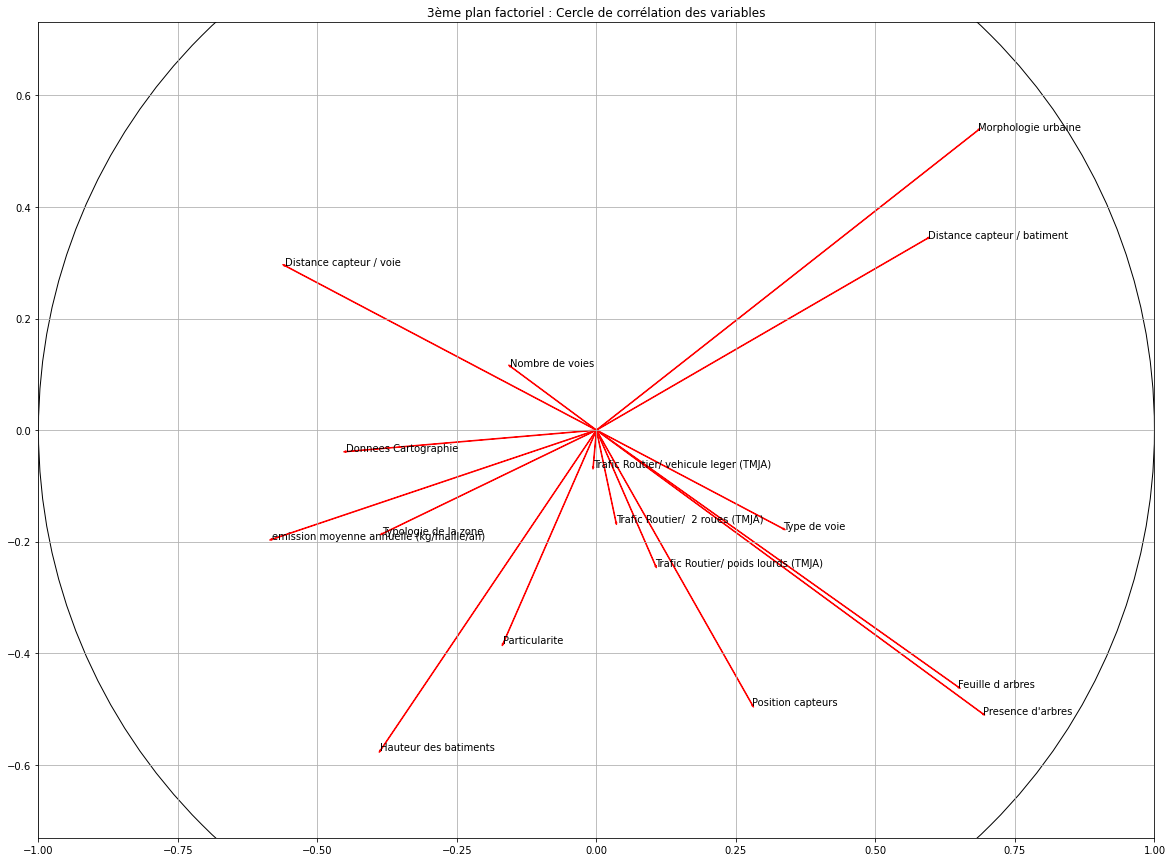

In [39]:
num_ax0=0
num_ax1=1

figure, axes = plt.subplots()

figure.set_figheight(15)
figure.set_figwidth(20)
circle=plt.Circle(( 0 , 0 ),1,fill = False)

# Affichage du troisième cercle de corrélation
Name_variable=Z_df.columns
for i, txt in enumerate(Name_variable):
    print(txt)
    plt.arrow(0,0,list_corr[i][1],list_corr[i][2],fc='r', ec='r')
    axes.annotate(txt, (list_corr[i][1], list_corr[i][2]))
plt.gca().add_artist(circle)
plt.title( '3ème plan factoriel : Cercle de corrélation des variables' )


plt.axis("equal")
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.grid()
plt.show()

##### TSNE

Visualisation des données par la méthode du t-SNE

C:\Users\ElieS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

C:\Users\ElieS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 97 samples in 0.000s...
[t-SNE] Computed neighbors for 97 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 97 / 97
[t-SNE] Mean sigma: 2.927788
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.973618
[t-SNE] KL divergence after 1000 iterations: 0.388593


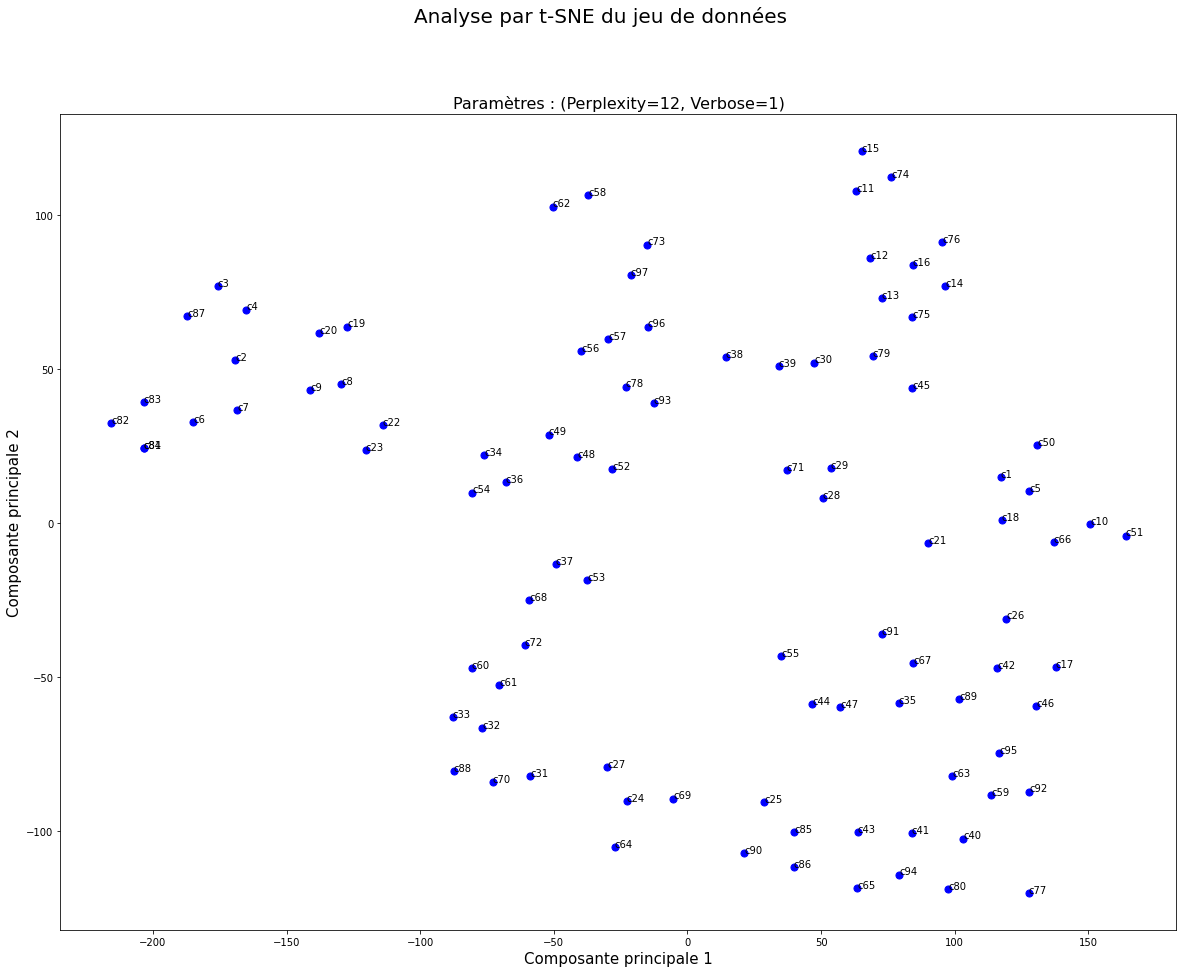

In [40]:
VERBOSE = 1 # Mode de présentation
PERPLEXITY = 12 # (i.e. le nombre de voisin qu’on souhaite autour d’un point valeur à prendre 
#entre 5 et 50 en général)
now=datetime.now().strftime("-%Y_%m_%d-%H_%M_%S")

tsne_2d = TSNE(n_components=2,verbose=VERBOSE,perplexity=PERPLEXITY,init="pca")

results_2d = tsne_2d.fit_transform(donneesOrdinalStandard)

principalDf_2d = pd.DataFrame(data = results_2d, columns = ["x", "y"])

secondDf_2d = pd.DataFrame(data =index_column.values, columns=["nom_capteur"])

# La matrice qui contient les coordonnées des individus transformées par la méthode du t-SNE
finalDf_2d = pd.concat([principalDf_2d, secondDf_2d[["nom_capteur"]]], axis = 1)

# Visualisation des données
TITLE = f"Analyse par t-SNE du jeu de données"
SUBTITLE = f"Paramètres : (Perplexity={PERPLEXITY}, Verbose={VERBOSE})"

fig,ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)

plt.suptitle(TITLE, fontsize=20)
plt.title(SUBTITLE, fontsize=16)
ax.set_xlabel('Composante principale 1', fontsize = 15)
ax.set_ylabel('Composante principale 2', fontsize = 15)

for index, row in finalDf_2d.iterrows():
  
    ax.scatter(row["x"]
            , row["y"]
            , c="blue"
            , s = 50)
    ax.annotate(row["nom_capteur"], (row["x"],row["y"]))

fig.savefig(DATA_IMG_FOLDER_PATH+'/'+TITLE+f'{now}.png', transparent=False, facecolor='w', bbox_inches='tight')
    

Sauvegarde des données issues du t-SNE (pour le projet)

In [41]:
#finalDf_2d.to_excel(f"{DATA_FOLDER_PATH}/donnees_environnement_capteur_pretraitement_tsne_{now}.xlsx")

### 2-6 : CLUSTERING DES DONNEES

##### Recherche exhaustive du meilleur partitionnement

Recherche du rayon optimale pour le DBSCAN avec les données de l'ACP

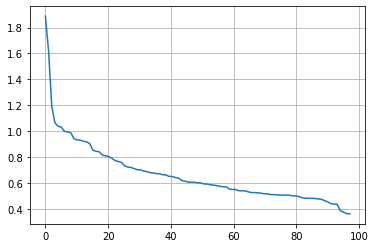

In [42]:
# Recherche de eps pour DBSCAN d'après le cours
NearestNeighbors(algorithm='brute', metric='euclidean')

# leafsize 30 par défaut pour DBSCAN
bt = NearestNeighbors(algorithm='ball_tree', leaf_size=30)
bt.fit(M[:,:2])

result_dist,_ = bt.kneighbors(np.array(M[:,:2]), 10, return_distance=True)
arr_dist_mean_k_neigh=[element.mean() for element in result_dist]
arr_dist_mean_k_neigh.sort(reverse=True)

# Affichage du graphe de la distance moyenne avec les k plus proches voisins
x=np.linspace(start=0,stop=len(arr_dist_mean_k_neigh),num=len(arr_dist_mean_k_neigh))
plt.plot(x,arr_dist_mean_k_neigh)
plt.grid()
plt.show()

Par lecture du graphe, on obtient le rayon pratique pour l'algorithme du DBSCAN.

Recherche du rayon optimale pour le DBSCAN avec les données du t-SNE

C:\Users\ElieS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



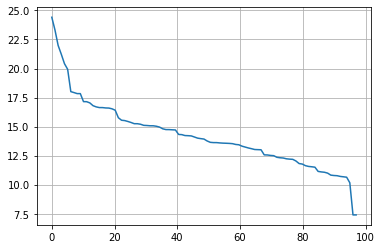

In [43]:
#Recherche de eps pour DBSCAN d'après le cours
NearestNeighbors(algorithm='brute', metric='euclidean')

#leafsize 30 par défaut pour DBSCAN
bt = NearestNeighbors(algorithm='ball_tree', leaf_size=30)
bt.fit(finalDf_2d[["x","y"]])

result_dist,_ = bt.kneighbors(np.array(finalDf_2d[["x","y"]]), 4, return_distance=True)
arr_dist_TSNE_mean_k_neigh=[element.mean() for element in result_dist]
arr_dist_TSNE_mean_k_neigh.sort(reverse=True)

# Affichage du graphe de la distance moyenne avec les k plus proches voisins
x=np.linspace(start=0,stop=len(arr_dist_TSNE_mean_k_neigh),num=len(arr_dist_TSNE_mean_k_neigh))
plt.plot(x,arr_dist_TSNE_mean_k_neigh)
plt.grid()
plt.show()

Par lecture du graphe, on obtient le rayon pratique pour l'algorithme du DBSCAN.

Recherche exhaustive des meilleurs hyperparamètres pour chacun des algorithmes de clustering avec les données de l'ACP

In [44]:
# Dictionnaire qui sauvegarde les résultats des algorithmes de clusters
labelsModelesACP = dict()

# L'espace de recherche
models = [
    ('K-Means', KMeans(), {'n_clusters': [4,5,6,7,8,9,10] , 'init': ['random' , 'k-means++']}),
    ('Mix Gaussien', GaussianMixture(), {'n_components' : [4,5,6,7,8,9,10] , 
    'max_iter' : [100 , 300] , 'init_params' : ['kmeans' , 'k-means++', 'random', 'random_from_data'] , 'n_init' : [2,3]}),
    ('DBSCAN', DBSCAN(), {'eps': [1,1.05,1.1] , 'min_samples' : [10]}),
    ('Partitionnement Spectral', SpectralClustering(), {'n_clusters': [4 , 5 , 6 , 7 , 8 , 9,10] , 
    'affinity' : ['nearest_neighbors' , 'rbf'] , 'assign_labels' : ['kmeans', 'discretize', 'cluster_qr']})
    ]

# Les données de l'ACP, on ne prend ici que les données issues du premier plan principal, car il a la plus grande qualité globale des trois plans principaux 
df_gridsearch = M[:,:2]

# On itère sur les différentes combinaisons d'hyperparamètres, ainsi que les méthodes de clustering
for model_name, model, param_grid in models:

    print(f"Entraînement et optimisation de {model_name}...")

    if model_name=="DBSCAN" or model_name=="Partitionnement Spectral":
        grid_search = GridSearchCV(model, param_grid, n_jobs = -1,scoring="accuracy")
    
        grid_search.fit(df_gridsearch)

        # Récupérons le modèle avec les meilleurs hyperparamètres
        best_model = grid_search.best_estimator_

        #Récupérons les clusters
        labels = best_model.fit_predict(df_gridsearch)
        labelsModelesACP[model_name] = labels
        
    else:
        grid_search = GridSearchCV(model, param_grid, n_jobs = -1)
    
        grid_search.fit(df_gridsearch)

        # Récupérons le modèle avec les meilleurs hyperparamètres
        best_model = grid_search.best_estimator_

        # Récupérons les clusters
        labels = best_model.predict(df_gridsearch)
        labelsModelesACP[model_name] = labels

    # Evaluons le modèle
    silhouette = silhouette_score(df_gridsearch, labels)
    
    ## L'ensemble des scores des différentes combinaisons d'hyperparamètres pour une méthode de clustering
    #scoresModelesACP = grid_search.cv_results_['mean_test_score']


    # Affichons les résultats
    print(f"Model : {model_name}")
    print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f"Score : {silhouette}")
    #print(f"Liste des scores des combinaisons : {scoresModelesACP}")
    print("--------------------")


Entraînement et optimisation de K-Means...


Model : K-Means
Meilleurs hyperparamètres : {'init': 'random', 'n_clusters': 10}
Score : 0.4100990316637227
--------------------
Entraînement et optimisation de Mix Gaussien...
Model : Mix Gaussien
Meilleurs hyperparamètres : {'init_params': 'random_from_data', 'max_iter': 300, 'n_components': 5, 'n_init': 2}
Score : 0.3357730743581665
--------------------
Entraînement et optimisation de DBSCAN...
Model : DBSCAN
Meilleurs hyperparamètres : {'eps': 1, 'min_samples': 10}
Score : 0.31213391529972057
--------------------
Entraînement et optimisation de Partitionnement Spectral...


C:\Users\ElieS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:953: UserWarning:

One or more of the test scores are non-finite: [nan nan nan]



Model : Partitionnement Spectral
Meilleurs hyperparamètres : {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'n_clusters': 4}
Score : 0.44069891446533427
--------------------


C:\Users\ElieS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:953: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]



Recherche exhaustive des meilleurs hyperparamètres pour chacun des algorithmes de clustering avec les données du t-SNE

In [45]:
# Dictionnaire qui sauvegarde les résultats des algorithmes de clusters
labelsModelesTSNE = dict()

# L'espace de recherche
models = [
    ('K-Means', KMeans(), {'n_clusters': [4,5,6,7,8,9,10] , 'init': ['random' , 'k-means++']}),
    ('Mix Gaussien', GaussianMixture(), {'n_components' : [4,5,6,7,8,9,10] , 
    'max_iter' : [100 , 300] , 'init_params' : ['kmeans' , 'k-means++', 'random', 'random_from_data'] , 'n_init' : [2,3]}),
    ('DBSCAN', DBSCAN(), {'eps': [18,19,20,21,22] , 'min_samples' : [2,3,4,5],'p':[1,2,3]}),
    ('Partitionnement Spectral', SpectralClustering(), {'n_clusters': [4 , 5 , 6 , 7 , 8 , 9,10] ,
    'affinity' : ['nearest_neighbors' , 'rbf'] , 'assign_labels' : ['kmeans', 'discretize', 'cluster_qr']})
    ]

# Les donnéess issues du t-SNE
df_gridsearch =finalDf_2d[["x","y"]]

# On itère sur les différentes combinaisons d'hyperparamètres, ainsi que les méthodes de clustering
for model_name, model, param_grid in models:

    print(f"Entraînement et optimisation de {model_name}...")

    if model_name=="DBSCAN" or model_name=="Partitionnement Spectral":
        grid_search = GridSearchCV(model, param_grid, n_jobs = -1, scoring="accuracy")
    
        grid_search.fit(df_gridsearch)

        # Récupérons le modèle avec les meilleurs hyperparamètres
        best_model = grid_search.best_estimator_

        # Récupérons les clusters
        labels = best_model.fit_predict(df_gridsearch)
        labelsModelesTSNE[model_name] = labels
        
        if model_name=="DBSCAN":
            l_labels_show=labels
    else:
        grid_search = GridSearchCV(model, param_grid, n_jobs = -1)
    
        grid_search.fit(df_gridsearch)

        # Récupérons le modèle avec les meilleurs hyperparamètres
        best_model = grid_search.best_estimator_

        # Récupérons les clusters
        labels = best_model.predict(df_gridsearch)
        
        labelsModelesTSNE[model_name] = labels
        

    # Evaluons le modèle
    silhouette = silhouette_score(df_gridsearch, labels) if len(set(labels))!=1 else "Pas pu faire de score 1 seul cluster trouvé"
    ## L'ensemble des scores des différentes combinaisons d'hyperparamètres pour une méthode de clustering
    #scoresModelesTSNE = grid_search.cv_results_['mean_test_score'] if len(set(labels))!=1 else "Pas pu enregistré le score 1 seul cluster trouvé"
    

    # Affichons les meilleurs hyperparamètres avec son coefficient de silhouette correspondant
    print(f"Model : {model_name}")
    print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f"Score : {silhouette}")
    #print(f"Liste des scores des combinaisons : {scoresModelesTSNE}")
    print("--------------------")


Entraînement et optimisation de K-Means...


Model : K-Means
Meilleurs hyperparamètres : {'init': 'k-means++', 'n_clusters': 10}
Score : 0.44493401050567627
--------------------
Entraînement et optimisation de Mix Gaussien...
Model : Mix Gaussien
Meilleurs hyperparamètres : {'init_params': 'kmeans', 'max_iter': 100, 'n_components': 5, 'n_init': 3}
Score : 0.40038740634918213
--------------------
Entraînement et optimisation de DBSCAN...


C:\Users\ElieS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:953: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]



Model : DBSCAN
Meilleurs hyperparamètres : {'eps': 18, 'min_samples': 2, 'p': 1}
Score : 0.3440549671649933
--------------------
Entraînement et optimisation de Partitionnement Spectral...
Model : Partitionnement Spectral
Meilleurs hyperparamètres : {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'n_clusters': 4}
Score : 0.4323274791240692
--------------------


C:\Users\ElieS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


12 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ElieS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 684, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\ElieS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python3

Observation des partitionnements des algorithmes avec leurs meilleurs hyperparamètres

K-Means
ACP


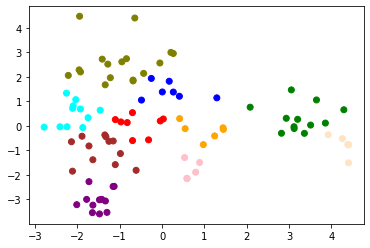

K-Means
TSNE


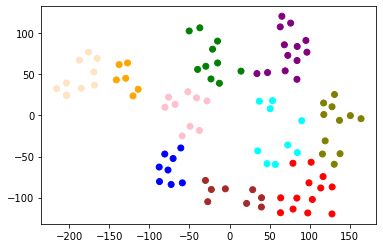

Mix Gaussien
ACP


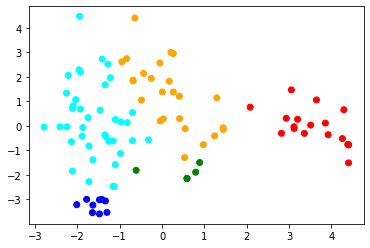

Mix Gaussien
TSNE


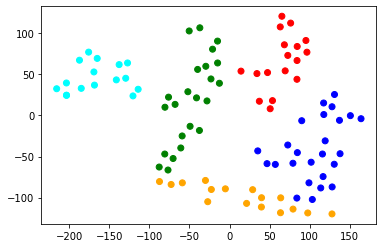

DBSCAN
ACP


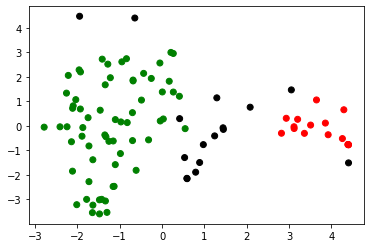

DBSCAN
TSNE


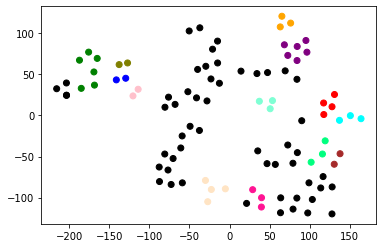

Partitionnement Spectral
ACP


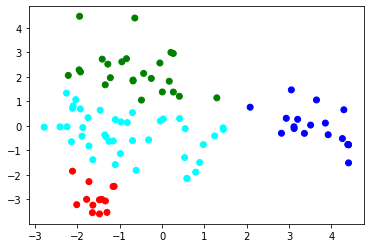

Partitionnement Spectral
TSNE


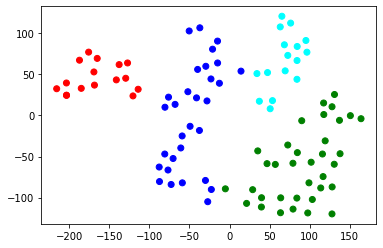

In [46]:
my_colors = {0:'red',1:'green',2:'blue',3:'cyan',4:'orange',5:'purple',6:'brown',7:'olive',8:'pink',9:'bisque',10:'deeppink',11:'springgreen',12:'aquamarine'}

for model_name , _ , _ in models:
    print(model_name)
    print("ACP")
    plt.scatter(M[:,0] , M[:,1], c=[my_colors.get(labelsModelesACP[model_name][i], 'black') for i,_ in enumerate(index_column) ])
    plt.show()

    print(model_name)
    print("TSNE")
    plt.scatter(finalDf_2d["x"] , finalDf_2d["y"], c=[my_colors.get(labelsModelesTSNE[model_name][i], 'black') for i,_ in enumerate(index_column) ])
    plt.show()

Recherche exhaustive des meilleurs hyperparamètres pour le CAH avec les données issues de l'ACP

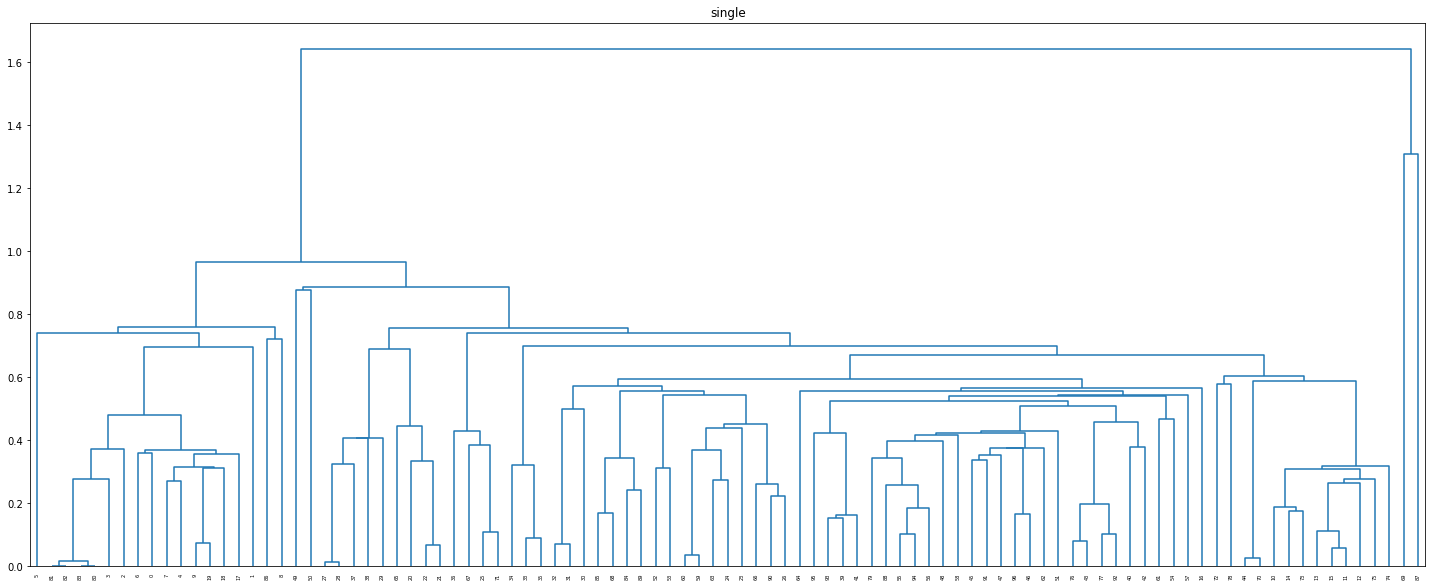

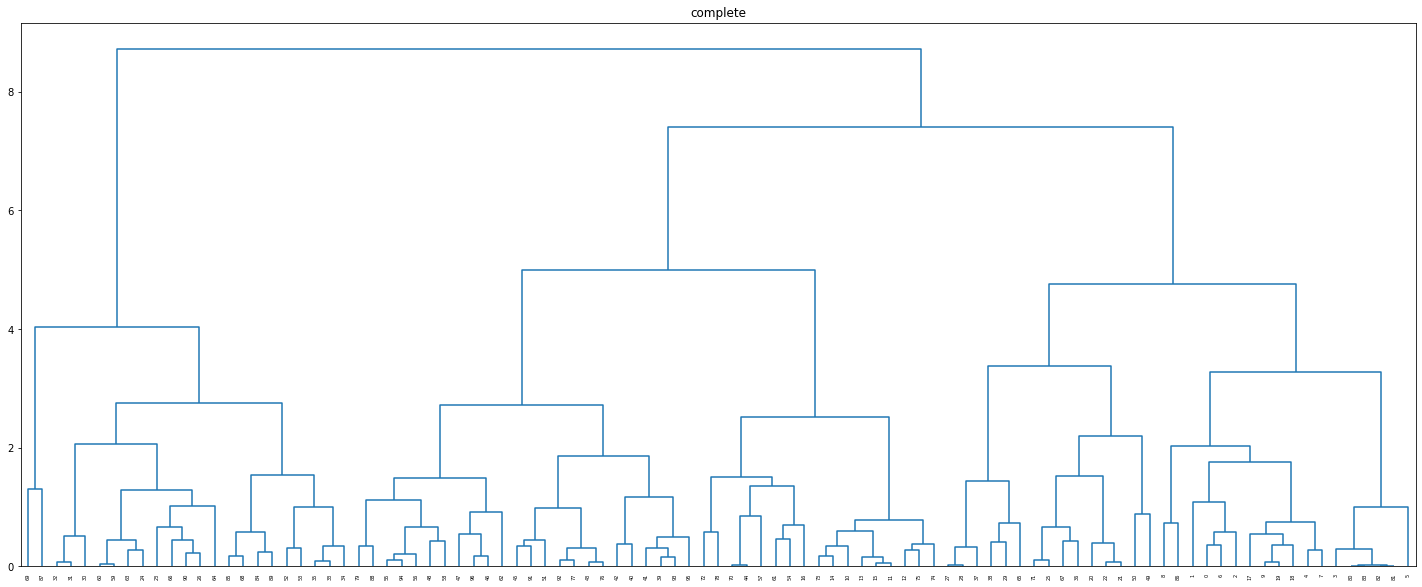

0.47687898480478425 4.03
[5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 5 5 5 4 4 4 1 1 4 1 4 4 4 1 1 1 1 1 1 4
 4 4 2 2 2 2 2 3 2 2 2 2 4 4 2 1 1 3 2 2 3 2 1 1 3 2 1 1 4 1 4 1 1 3 4 3 3
 3 3 2 2 3 2 5 5 5 5 1 1 5 1 2 1 1 2 2 2 2 2 2]


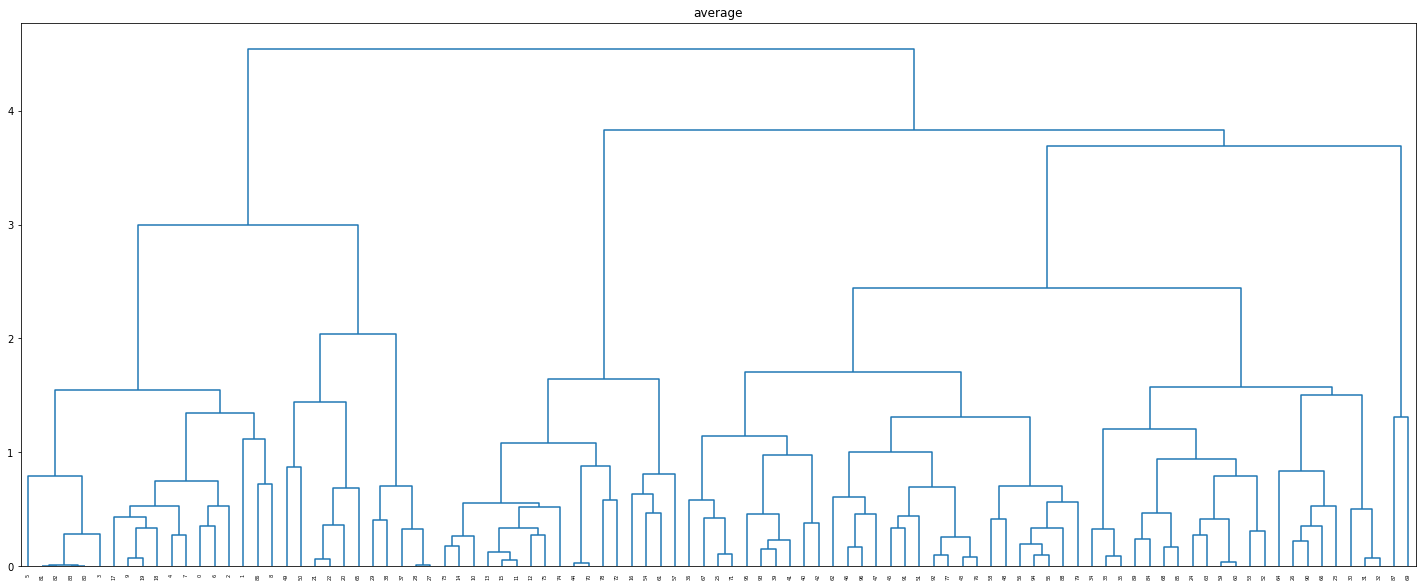

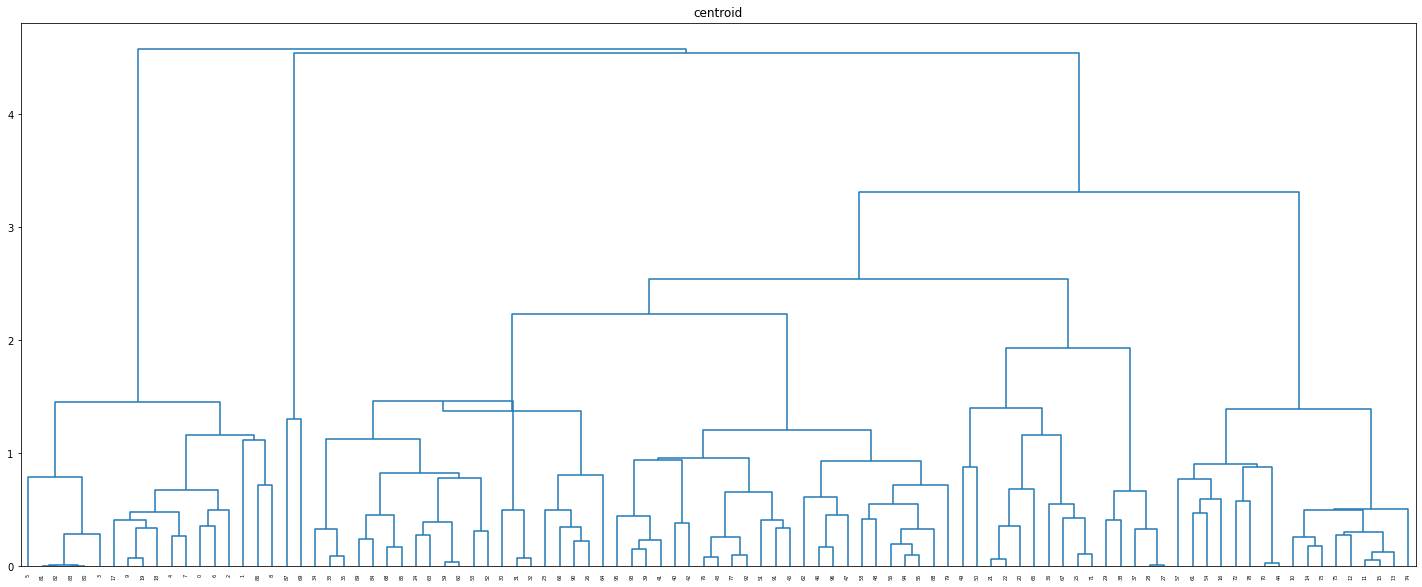

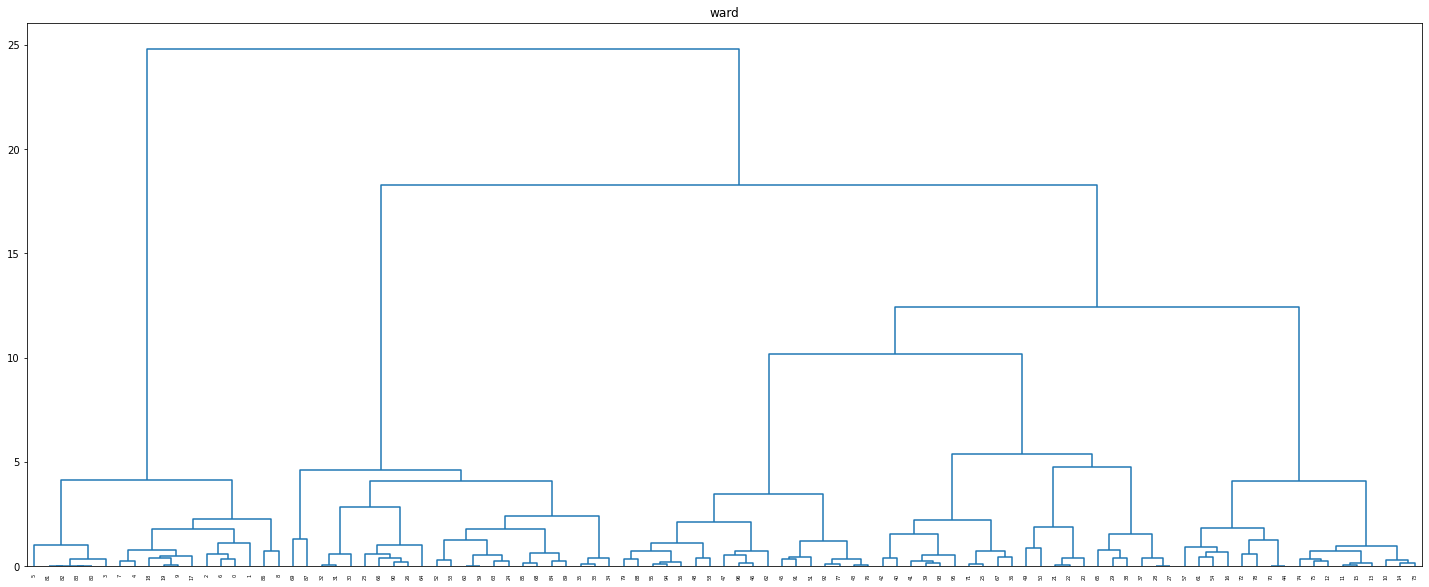

0.4687557530583925 1.11
[ 3  3  3  1  2  1  3  2  4  2 27 27 27 27 27 27 24  2  2  2 21 21 21  8
 10 19  8 23 23 22  7  7  7 12 12 12 19 23 22 18 17 18 17 16 26 15 14 14
 13 20 20 15  9  9 24 13 13 24 13 10 10 24 14 10  8 22  8 19 11  5 26 19
 25 27 27 27 16 16 25 13  1  1  1  1 11 11  4  6 13 11  8 15 16 18 13 18
 14]


In [47]:
distances=[
            "single",
            "complete",
            "average",
            "centroid",
            "ward"
            ]

# Les données issues de l'ACP
Y=M[:,:2]

# Itérations sur les distances
for distance in distances:
    Z = linkage(Y, optimal_ordering=True,method=distance)
    fig = plt.figure(figsize=(25, 10))
    plt.title(f"{distance}")
    dn = dendrogram(Z, color_threshold=0)
    plt.show()

    # Détermination du meilleur seuil, pour obtenir le meilleur coefficient de Silhouette
    if distance == "complete":
        l_complete=[silhouette_score(Y,labels=fcluster(Z, t/100, criterion='distance')) for t in range(0,500,1)]
        print(max(l_complete),l_complete.index(max(l_complete))/100)
        l_index_cah_complete=fcluster(Z, t=l_complete.index(max(l_complete))/100, criterion='distance')
        print(fcluster(Z, t=l_complete.index(max(l_complete))/100, criterion='distance'))
    if distance == "ward":
        l_ward=[silhouette_score(Y,labels=fcluster(Z, t/100, criterion='distance')) for t in range(0,1000,1)]
        print(max(l_ward),l_ward.index(max(l_ward))/100)
        l_index_cah_ward=fcluster(Z, t=l_ward.index(max(l_ward))/100, criterion='distance')
        print(fcluster(Z, t=l_ward.index(max(l_ward))/100, criterion='distance'))


Observation du CAH selon la distance "linkage complete" sur les données issues de l'ACP

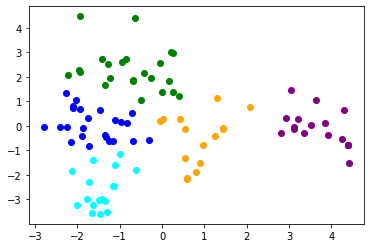

In [48]:
fig, ax = plt.subplots()

my_colors = {0:'red',1:'green',2:'blue',3:'cyan',4:'orange',5:'purple',6:'brown'}

for i, txt in enumerate(index_column):
    ax.scatter(X_new[i] , Y_new[i], color = my_colors.get(l_index_cah_complete[i], 'black'))

Observation du CAH selon la distance "ward" sur les données issues de l'ACP

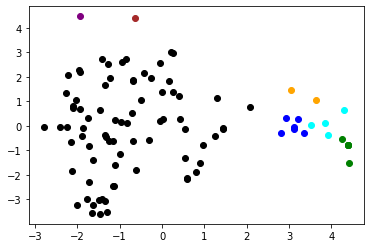

In [49]:
fig, ax = plt.subplots()

my_colors = {0:'red',1:'green',2:'blue',3:'cyan',4:'orange',5:'purple',6:'brown'}

for i, txt in enumerate(index_column):
    ax.scatter(X_new[i] , Y_new[i], color = my_colors.get(l_index_cah_ward[i], 'black'))

Recherche exhaustive des meilleurs hyperparamètres pour le CAH avec les données issues du t-SNE

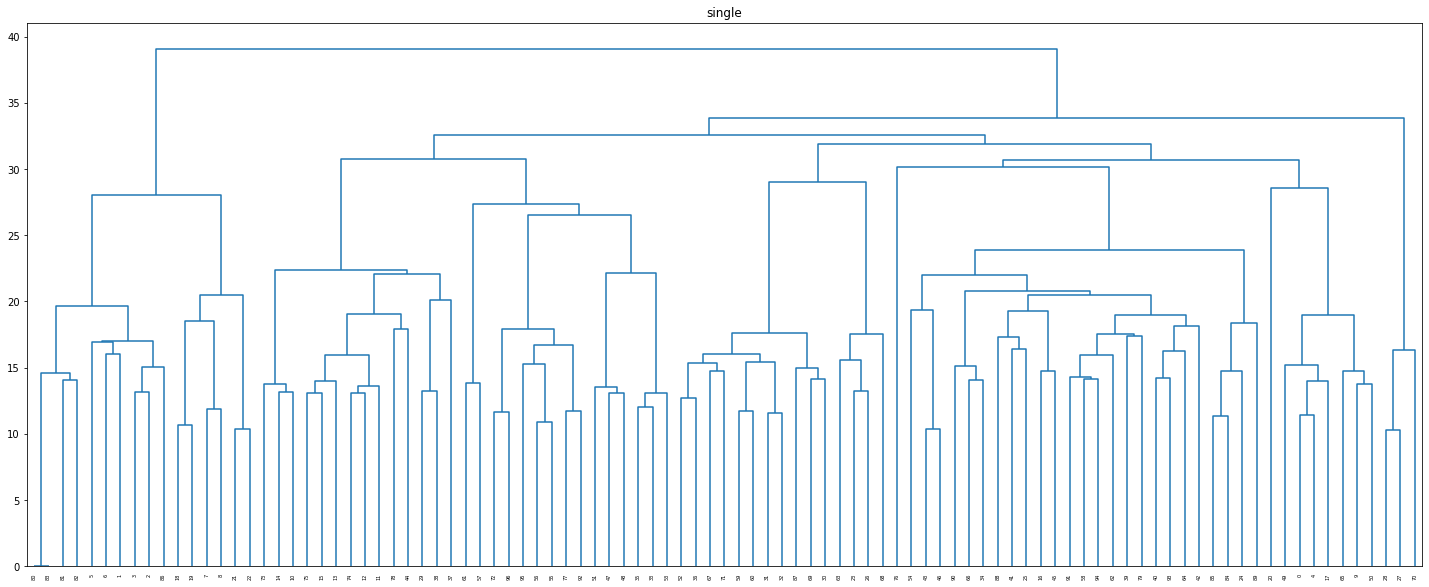

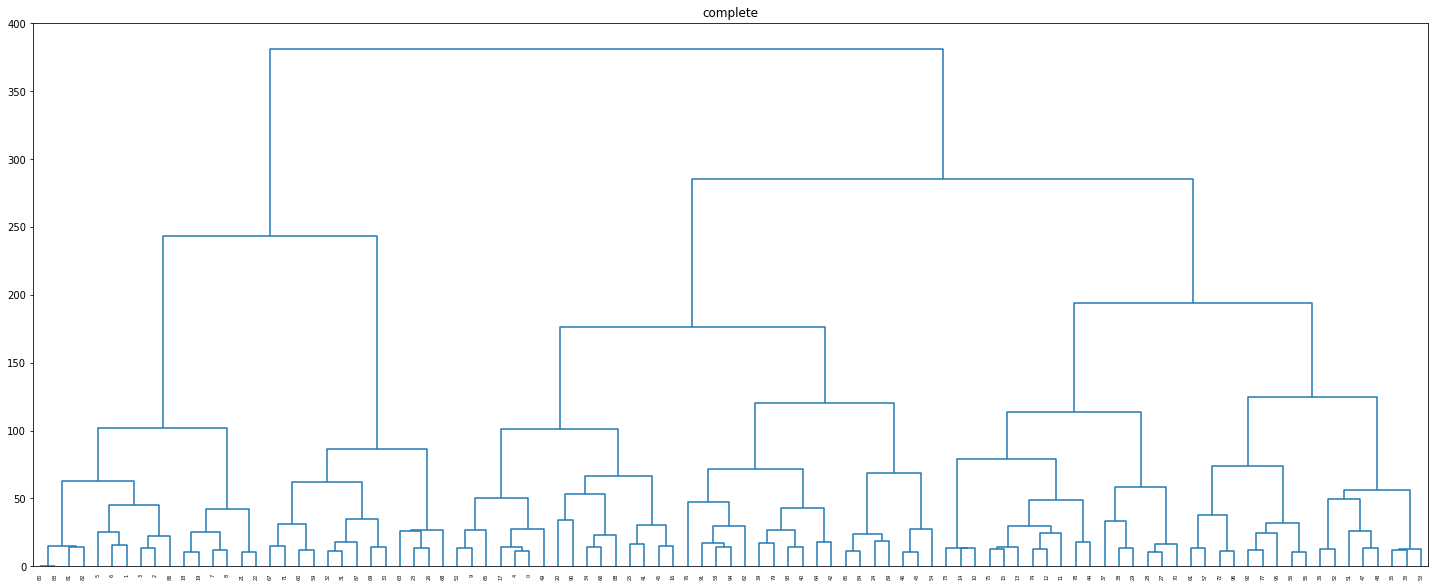

0.45635834 130
[3 1 1 1 3 1 1 1 1 3 5 5 5 5 5 5 3 3 1 1 3 1 1 2 4 3 2 5 5 5 2 2 2 6 3 6 6
 5 5 4 4 3 4 4 5 3 4 6 6 3 3 6 6 6 4 6 6 6 4 2 2 6 4 2 4 3 3 2 2 2 5 2 6 5
 5 5 4 6 5 4 1 1 1 1 4 4 1 2 3 4 3 4 6 4 4 6 6]


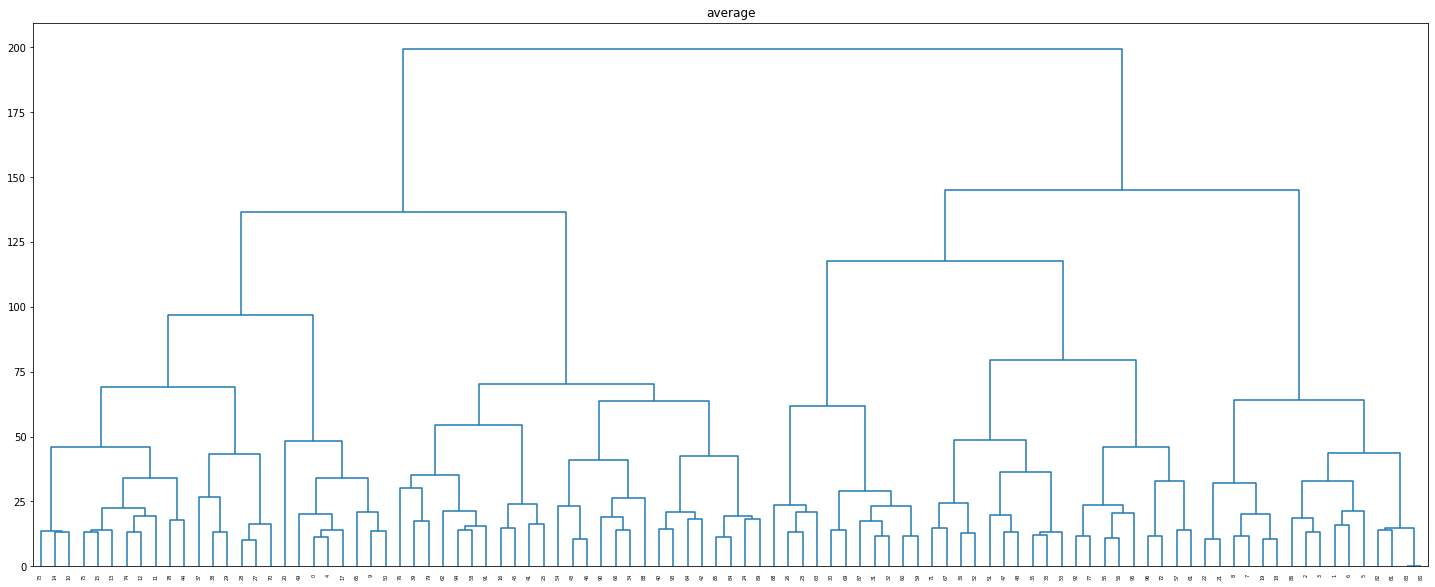

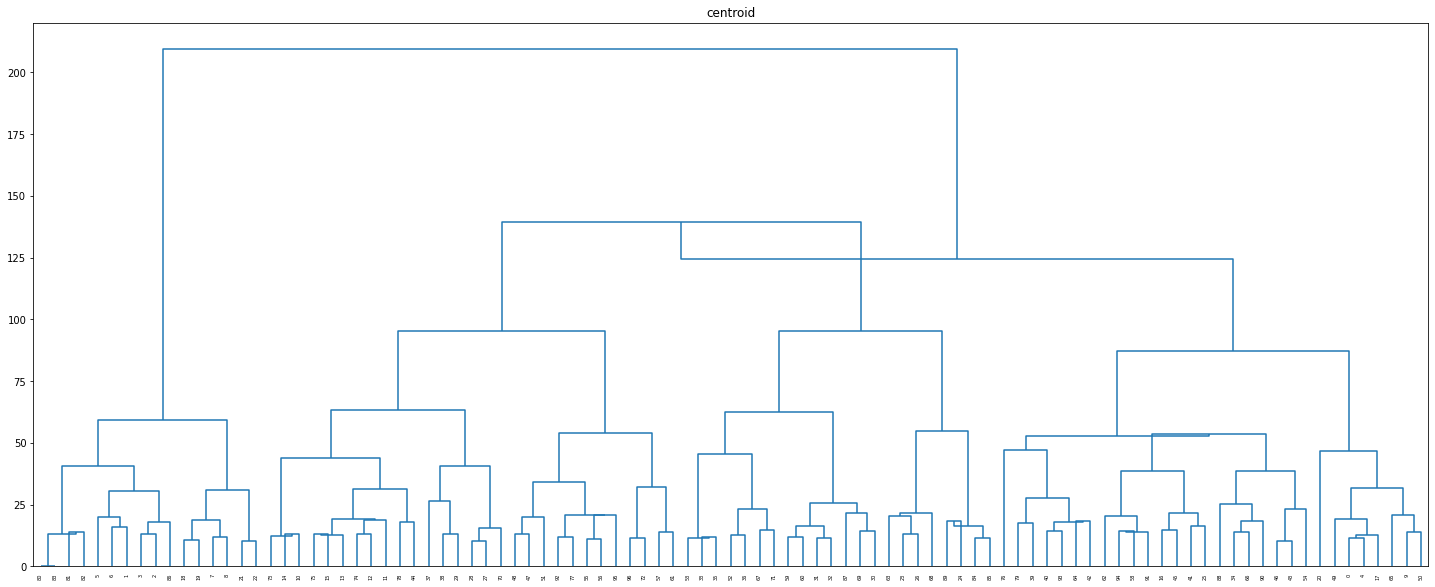

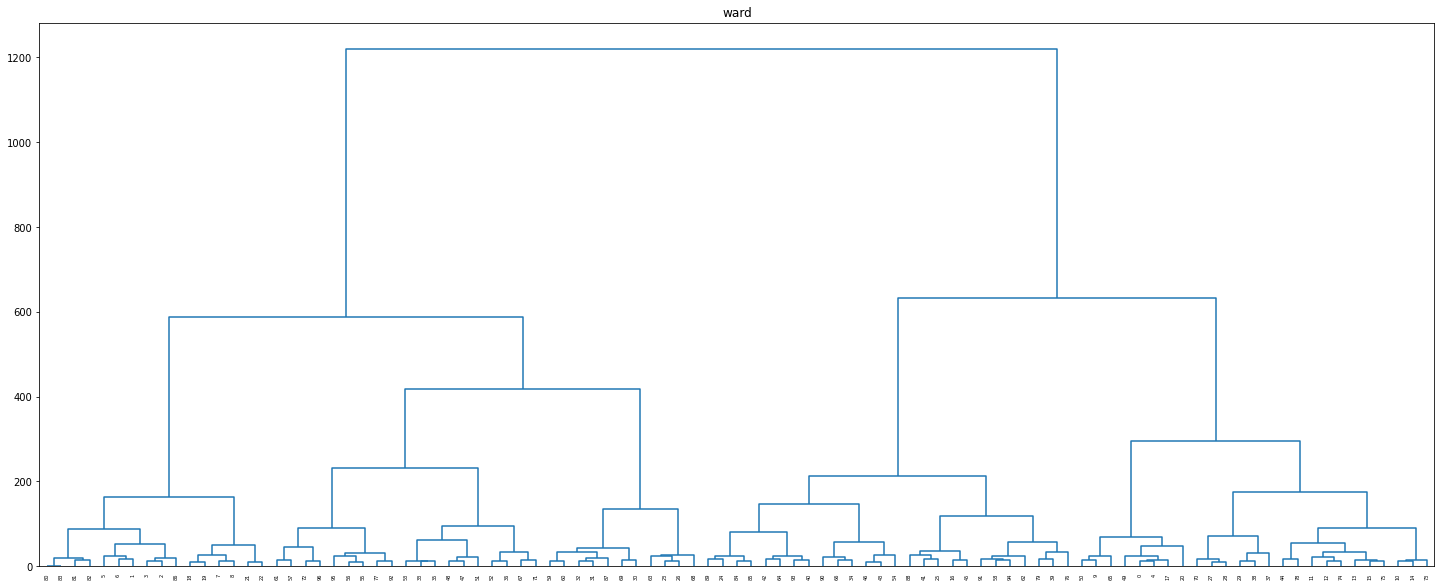

0.4646112 295
[5 1 1 1 5 1 1 1 1 5 5 5 5 5 5 5 4 5 1 1 5 1 1 3 4 4 3 5 5 5 3 3 3 2 4 2 2
 5 5 4 4 4 4 4 5 4 4 2 2 5 5 2 2 2 4 2 2 2 4 3 3 2 4 3 4 5 4 2 3 3 5 2 2 5
 5 5 4 2 5 4 1 1 1 1 4 4 1 3 4 4 4 4 2 4 4 2 2]


In [50]:
distances=[
    "single",
    "complete",
    "average",
    "centroid",
    "ward"
    ]

# Les données issues du t-SNE
Y=finalDf_2d[["x","y"]]

# Itérations sur les distances
for distance in distances:
    Z = linkage(Y, optimal_ordering=True,method=distance)
    fig = plt.figure(figsize=(25, 10))
    plt.title(f"{distance}")
    dn = dendrogram(Z, color_threshold=0)
    plt.show()

    # Détermination du meilleur seuil, pour obtenir le meilleur coefficient de Silhouette
    if distance == "complete":
        l_complete=[silhouette_score(Y,labels=fcluster(Z, t, criterion='distance')) for t in range(0,150,5)]
        print(max(l_complete),l_complete.index(max(l_complete))*5)
        l_index_cah_complete_tsne=fcluster(Z, t=l_complete.index(max(l_complete))*5, criterion='distance')
        print(fcluster(Z, t=l_complete.index(max(l_complete))*5, criterion='distance'))
    if distance == "ward":
        l_ward=[silhouette_score(Y,labels=fcluster(Z, t, criterion='distance')) for t in range(0,300,5)]
        print(max(l_ward),l_ward.index(max(l_ward))*5)
        l_index_cah_ward_tsne=fcluster(Z, t=l_ward.index(max(l_ward))*5, criterion='distance')
        print(fcluster(Z, t=l_ward.index(max(l_ward))*5, criterion='distance'))

Observation du CAH selon la distance "ward" avec le t-SNE

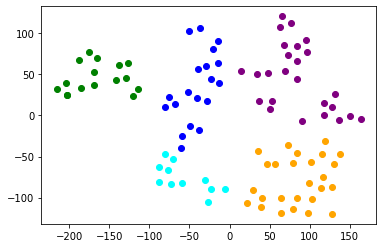

In [51]:
fig, ax = plt.subplots()

my_colors = {0:'red',1:'green',2:'blue',3:'cyan',4:'orange',5:'purple',6:'brown',7:'olive',8:'pink'}

for i, txt in enumerate(index_column):
    ax.scatter(finalDf_2d["x"][i] ,finalDf_2d["y"][i], color = my_colors.get(l_index_cah_ward_tsne[i], 'black'))

On constate que le meilleur algorithme avec les meilleurs hyperparamètres est le CAH avec comme distance 'linkage complete' et un seul t=4,03 sur les données fournies par l'ACP.
On sauvegarde ce partitionnement dans un excel qui reprend les données originelles et une nouvelle colonne qui indique l'appartenance à un cluster pour chaque ligne.

In [52]:
df_clusters=donnees.copy(True)
df_clusters["clusters"]=l_index_cah_complete
#df_clusters.to_excel(f"{DATA_FOLDER_PATH}/donnees_tSNE{now}.xlsx")

##### Vérification de la pertinence du meilleur partitionnement

La description du jeu de données de vérification

In [53]:
mesures.describe()

,c1,c3,c5,c7,c8,c10,c11,c13,c14,c19,...,c31,c87,c50,c51,c64,c73,c74,c75,c76,c90
count,22679.000000,22817.000000,22428.000000,16003.000000,19543.000000,22067.000000,24340.000000,20490.000000,23649.000000,24106.000000,...,23020.000000,20360.000000,23988.000000,24173.000000,23808.000000,23726.000000,23811.000000,24919.000000,20229.000000,22615.000000
mean,4.230878,143.879774,3.759503,4.727124,3.838585,4.006110,4.762711,5.570949,5.424741,4.326096,...,4.692523,6.506445,4.472243,4.448952,98.214946,4.541791,3.663883,4.899203,5.384154,3.682320
std,4.159081,287.764391,4.139841,3.957796,3.549323,4.355662,4.607703,5.721227,5.483428,102.922434,...,6.067209,7.337092,4.764511,5.422009,362.107189,4.479097,4.090825,5.293554,5.343375,7.380765
min,0.101000,0.062000,0.125000,0.113000,0.087000,0.060000,0.080000,0.087000,0.073000,0.084000,...,0.082000,0.237000,0.000000,0.000000,0.099000,0.087000,0.069000,0.088000,0.078000,0.060000
25%,1.826000,2.326000,1.582000,2.209000,1.731000,1.631000,2.095000,2.232000,2.238000,1.460250,...,1.633000,2.248750,1.866750,1.397000,2.353000,1.914000,1.476000,1.961000,2.257000,1.307000
50%,2.940000,4.512000,2.579000,3.584000,2.742000,2.659000,3.308000,3.671500,3.683000,2.382000,...,2.774500,4.069000,2.968500,2.914000,4.190000,3.108000,2.308000,3.150000,3.702000,2.202000
75%,4.781000,21.238000,4.187250,5.622000,4.515500,4.424500,5.338000,6.194750,6.105000,3.929000,...,4.905250,7.468500,4.810250,5.348000,8.500250,5.125000,3.864000,5.391500,5.996000,3.869500
max,47.209000,1628.360000,116.258000,47.343000,83.765000,84.358000,51.257000,64.449000,78.706000,15207.625000,...,130.536000,261.813000,82.859000,188.449000,2262.048000,77.141000,69.857000,124.285000,46.010000,405.893000


On repère le nombre de valeurs manquantes pour chaque colonne de ce jeu de données

In [54]:
mesures.isna().sum()

Date        0
c1       3105
c3       2967
c5       3356
c7       9781
c8       6241
c10      3717
c11      1444
c13      5294
c14      2135
c19      1678
c16      2034
c17      1960
c22      3366
c23       825
c26     12107
c27     10776
c28      3918
c29      3429
c31      2764
c87      5424
c50      1796
c51      1611
c64      1976
c73      2058
c74      1973
c75       865
c76      5555
c90      3169
dtype: int64

Enlevons toutes les colonnes dont au moins un tier des valeurs sont manquantes

In [55]:
nanMesures = list(mesures.isna().sum()) # Le nombre de valeurs manquantes pour chaque colonne

seuilNanMesures = len(mesures) // 3

for i , nombreDeNanColonne in enumerate(nanMesures):
    if nombreDeNanColonne >= seuilNanMesures:
        mesures.drop(mesures.columns[i] , axis = 1 , inplace = True)
        
# Méthode qui remplace la valeur manquante par la valeur qui la précède dans la même colonne
mesures.fillna(method='ffill', inplace=True)
colonnesMesures = mesures.columns

Graphe des concentrations de particules fines en fonction du temps pour chaque cluster avec les données aberrantes

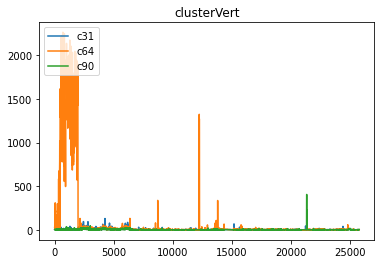

<Figure size 1440x720 with 0 Axes>

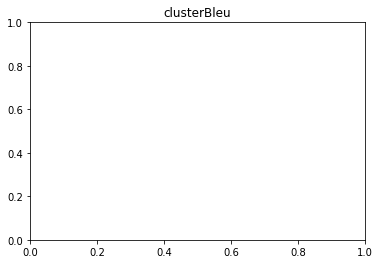

<Figure size 1440x720 with 0 Axes>

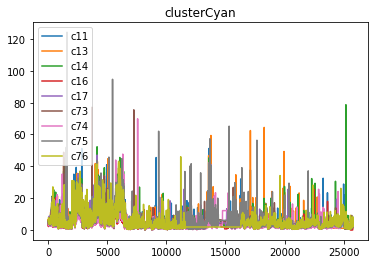

<Figure size 1440x720 with 0 Axes>

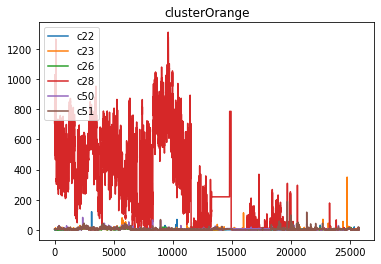

<Figure size 1440x720 with 0 Axes>

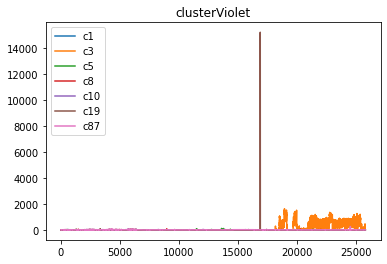

<Figure size 1440x720 with 0 Axes>

In [56]:
# Nous avons écrit les associations de capteur à son cluster correspondant
# Ces clusters sont les clusters créés par l'algorithme, retenue selon nos critères, CAH selon la distance 'complete' et le seuil t=4,03
clusters_labels_verification = [[index_column[indice_nom_capteur],cluster] for indice_nom_capteur,cluster in enumerate(l_index_cah_complete)]
sorted(clusters_labels_verification, key=lambda x: (x[1]))
clusterVert=[element[0] for element in clusters_labels_verification if element[1]==1]
clusterBleu=[element[0] for element in clusters_labels_verification if element[1]==2]
clusterCyan=[element[0] for element in clusters_labels_verification if element[1]==3]
clusterOrange=[element[0] for element in clusters_labels_verification if element[1]==4]
clusterViolet=[element[0] for element in clusters_labels_verification if element[1]==5]

clustersFinaux = [clusterVert , clusterBleu , clusterCyan , clusterOrange , clusterViolet]
nomsClusterFinaux = ["clusterVert" , "clusterBleu" , "clusterCyan" , "clusterOrange" , "clusterViolet"]

# Affichage des graphes 
for i , c in enumerate(clustersFinaux):
    for capteur in c:
        
        if capteur in colonnesMesures:
            
            plt.plot(np.linspace(0,mesures.shape[0],mesures.shape[0]), mesures[capteur].values , label = capteur)
            plt.legend(loc="upper left")
        
        plt.title(nomsClusterFinaux[i])
    plt.figure(figsize=(20,10))
    plt.show()


Une celulle qui enlève les valeurs aberrantes de la variable "mesure" qui contient le jeu de données

In [57]:
seuil_aberation=1.5
pourcentage_premier_quartile = 25
pourcentage_deuxieme_quartile = 50
pourcentage_dernier_quartile = 75
res={}
mesures_sans_valeurs_aberrantes=mesures.copy(deep=True)
for name in mesures_sans_valeurs_aberrantes.columns[1:]:
    res[f"{name}"]=[]

    q1=np.percentile(mesures_sans_valeurs_aberrantes[name],pourcentage_premier_quartile)
    median = np.percentile(mesures_sans_valeurs_aberrantes[name],pourcentage_deuxieme_quartile)
    q3=np.percentile(mesures_sans_valeurs_aberrantes[name],pourcentage_dernier_quartile)

    distance_interquartile=abs(q1-q3)
    
    for index, element in enumerate(mesures_sans_valeurs_aberrantes[name].values):
        if element>q3+seuil_aberation*distance_interquartile or element<q1-seuil_aberation*distance_interquartile:
            res[f"{name}"].append(mesures_sans_valeurs_aberrantes[name][index])
            mesures_sans_valeurs_aberrantes[name][index]=median


C:\Users\ElieS\AppData\Local\Temp/ipykernel_20896/2337565662.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
l_index_cah_complete

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 4, 4,
       4, 1, 1, 4, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 4, 4, 4, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 4, 4, 2, 1, 1, 3, 2, 2, 3, 2, 1, 1, 3, 2, 1, 1, 4,
       1, 4, 1, 1, 3, 4, 3, 3, 3, 3, 2, 2, 3, 2, 5, 5, 5, 5, 1, 1, 5, 1,
       2, 1, 1, 2, 2, 2, 2, 2, 2], dtype=int32)

Graphe des concentrations de particules fines en fonction de temps pour chaque cluster sans les données aberrantes

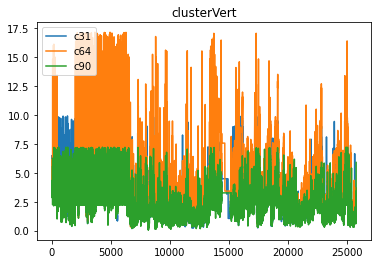

<Figure size 1440x720 with 0 Axes>

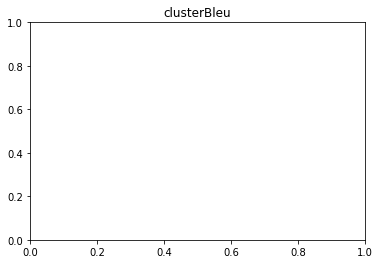

<Figure size 1440x720 with 0 Axes>

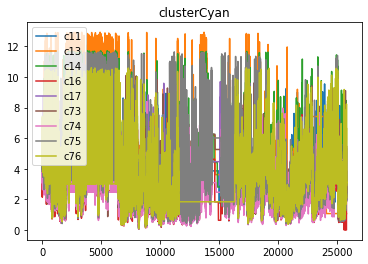

<Figure size 1440x720 with 0 Axes>

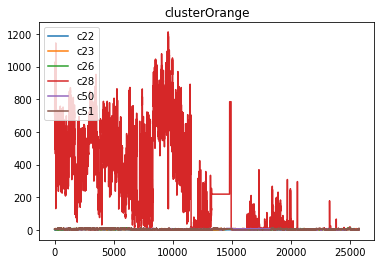

<Figure size 1440x720 with 0 Axes>

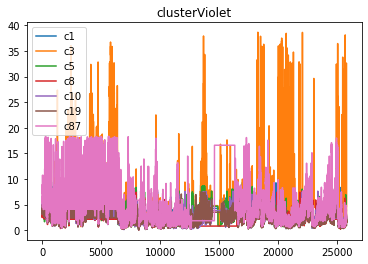

<Figure size 1440x720 with 0 Axes>

In [59]:
#Affichage des graphes
for i , c in enumerate(clustersFinaux):
    for capteur in c:
        if capteur in colonnesMesures:
            plt.plot(np.linspace(0,mesures_sans_valeurs_aberrantes.shape[0], mesures_sans_valeurs_aberrantes.shape[0]), mesures_sans_valeurs_aberrantes[capteur].values, label = capteur)
            plt.legend(loc="upper left")  
        plt.title(nomsClusterFinaux[i])
    plt.figure(figsize=(20,10))
    plt.show()